<a href="https://colab.research.google.com/github/a-foote/DATA586G8_FraudDetector/blob/alyssa/Model_NN%20Classifier_Balanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# Credit Card Fraud Detector - Neural Net Classifier Model

## Template: Lab 2 and Lab 3

In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import seaborn as sn
import numpy as np

In [3]:
df_train = pd.read_csv('fraud_trainset_smote_nodupe.csv')

In [4]:
#df_val = pd.read_csv('fraud_valset_smote.csv')

In [5]:
df_test = pd.read_csv('fraud_testset_nodupe.csv')

In [6]:
# Convert dataframe to numpy array for downstream model processing

train_dataset=df_train.to_numpy() #This is used in dataloader
test_dataset=df_test.to_numpy() #This is used in dataloader


## Validate the data in the train dataset to ensure the records are transformed correctly as expected

In [7]:
train_dataset.shape

(453204, 31)

In [8]:
df_train.head()

,amount_scaled,time_scaled,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.221666,-0.377686,-2.884963,-1.589646,1.428892,-0.231664,0.703769,-1.135737,1.374058,-1.270979,...,-1.467870,-0.561406,1.176544,1.317806,0.552698,0.080118,1.087925,0.008199,-0.826939,0
1,-0.055764,-0.682481,1.346320,-0.487437,0.592587,-0.777410,-1.044706,-0.716309,-0.615366,-0.069492,...,0.117686,-0.034576,-0.262912,0.110504,0.311770,0.206979,-0.500379,0.006710,0.014698,0
2,-0.292032,-0.000781,-1.218391,-0.255592,2.260171,-2.202368,0.837064,0.202872,0.026945,0.005451,...,0.053011,-0.106944,0.299457,-0.607956,-0.825759,0.491154,-0.750612,-0.015709,-0.364491,0
3,0.917675,0.139183,1.857971,-0.028326,-1.670878,1.474285,0.567250,-0.580874,0.491246,-0.306005,...,-0.214325,-0.031796,0.130834,-0.103224,-0.469414,0.391725,-0.530875,-0.066009,-0.069885,0
4,-0.268530,-0.081481,-0.656697,1.012916,1.444790,0.157903,0.034674,-0.868656,0.610683,-0.007874,...,0.032794,-0.192946,-0.458896,0.210743,0.554074,-0.281893,0.060908,0.145721,0.083991,0


In [9]:
train_dataset

array([[ 1.22166597e+00, -3.77685657e-01, -2.88496303e+00, ...,
         8.19860979e-03, -8.26939315e-01,  0.00000000e+00],
       [-5.57641496e-02, -6.82480690e-01,  1.34631967e+00, ...,
         6.71017800e-03,  1.46975322e-02,  0.00000000e+00],
       [-2.92031706e-01, -7.81495595e-04, -1.21839148e+00, ...,
        -1.57087660e-02, -3.64491084e-01,  0.00000000e+00],
       ...,
       [ 1.13256695e+00, -5.08650425e-01, -1.51004445e+01, ...,
        -2.42812048e+00, -1.17370065e+00,  1.00000000e+00],
       [-2.93229441e-01,  9.66105650e-01,  1.30109703e+00, ...,
         3.78672628e-01,  1.57972035e-01,  1.00000000e+00],
       [-2.92031706e-01, -8.54082823e-01, -2.41180375e+00, ...,
         2.00529903e+00,  9.11994705e-01,  1.00000000e+00]])

## Neural Net Model

In [10]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.1
BATCH_SIZE = 40000
NUM_EPOCHS = 100

# Architecture
NUM_FEATURES = 30
NUM_CLASSES = 2

# Other
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"

GRAYSCALE = False

In [11]:
###########################
### Dataset
##########################

#Transform and augmentation, validation, 

#Split X (features) and y (targets) for the dataset
X=np.delete(train_dataset,-1,axis=1)
y = np.delete(train_dataset,np.s_[0:30],axis=1).flatten()


#View a sample of X and y

X
y

array([0., 0., 0., ..., 1., 1., 1.])

In [12]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):
    loader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=BATCH_SIZE)
    for batch_idx, (X_batch, y_batch) in enumerate(loader):
           
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y_batch.size()[0])
        
        x_b = X_batch
        print(x_b)
        y_b = y_batch
        print(y_b)
        break

Epoch: 1 | Batch index: 0 | Batch size: 40000
tensor([[-0.1669, -0.4406, -2.5781,  ...,  0.8091, -0.2260, -0.3951],
        [-0.3022,  0.0910,  0.8164,  ...,  0.2640,  0.5141,  0.3563],
        [ 0.5980, -0.8904, -0.4885,  ..., -0.5533, -0.0473, -0.0512],
        ...,
        [-0.2374, -0.5731, -3.8659,  ...,  0.4081,  0.6573,  0.5054],
        [ 0.3616,  0.4118, -0.9245,  ...,  0.1114,  0.1812,  0.1419],
        [-0.0280, -0.3701, -1.2350,  ..., -0.4150,  0.0939,  0.0637]],
       dtype=torch.float64)
tensor([0., 1., 0.,  ..., 1., 0., 0.], dtype=torch.float64)
Epoch: 2 | Batch index: 0 | Batch size: 40000
tensor([[ 4.5360,  0.8881, -1.0218,  ..., -0.2810,  0.3948,  0.0691],
        [ 0.6430,  0.8131, -0.7603,  ...,  0.3763,  0.3864,  0.1992],
        [ 2.6005, -0.9634, -0.7333,  ...,  0.2366, -0.0985, -0.1666],
        ...,
        [-0.2258, -0.2617, -4.0256,  ...,  0.2197,  0.4375,  0.0637],
        [ 1.6966, -0.3465,  1.0902,  ..., -0.2217,  0.0552,  0.0511],
        [ 0.5284, -0.38

In [13]:
##########################
### MODEL
##########################

## 4/29Add dropout
class NeuNet(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(NeuNet, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
#no convolution layers were used            
            #nn.Conv2d(in_channels, 6*in_channels, kernel_size=5),
            #nn.Conv1d(28,50,kernel_size=5),
            #nn.Tanh(),
            #nn.MaxPool2d(kernel_size=2),
            #nn.MaxPool1d(kernel_size=2),
            #nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5),
            #nn.Conv1d(50,50,kernel_size=5),
            #nn.Tanh(),
            #nn.MaxPool1d(kernel_size=2)
            #nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
# tuning: Added drop out to reduce overfitting
# tuning: Changed to Relu6 activation function
# tuning: Changed the number of neurons in the hidden layers
# tuning: Added and removed new layers
            nn.Linear(30, 50),
            nn.Tanh(),
            nn.Dropout(0.02),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Dropout(0.02),
            nn.Linear(50, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        
        #out = self.linear_1(x)
        #out = F.relu(out)
        
        #logits = self.linear_out(out)
        #probas = F.softmax(logits, dim=1)
        #return logits, probas
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [14]:

torch.manual_seed(RANDOM_SEED)

model1 = NeuNet(NUM_CLASSES, GRAYSCALE)
model1 = model1.to(DEVICE)


#4/29 add weight_decay=0.00091
optimizer = torch.optim.Adam(model1.parameters(), LEARNING_RATE,weight_decay=0.0000000123)

# Training

C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 001/100 | Batch 0000/0012 | Cost: 0.7099
Epoch: 001/100 | Batch 0001/0012 | Cost: 0.5393
Epoch: 001/100 | Batch 0002/0012 | Cost: 0.4704
Epoch: 001/100 | Batch 0003/0012 | Cost: 0.6194
Epoch: 001/100 | Batch 0004/0012 | Cost: 0.3280
Epoch: 001/100 | Batch 0005/0012 | Cost: 0.4454
Epoch: 001/100 | Batch 0006/0012 | Cost: 0.3097
Epoch: 001/100 | Batch 0007/0012 | Cost: 0.2263
Epoch: 001/100 | Batch 0008/0012 | Cost: 0.3067
Epoch: 001/100 | Batch 0009/0012 | Cost: 0.2375
Epoch: 001/100 | Batch 0010/0012 | Cost: 0.1956
Epoch: 001/100 | Batch 0011/0012 | Cost: 0.2247
              precision    recall  f1-score   support

           0       0.90      0.96      0.93    226602
           1       0.96      0.90      0.93    226602

    accuracy                           0.93    453204
   macro avg       0.93      0.93      0.93    453204
weighted avg       0.93      0.93      0.93    453204

F1 Score:  0.9276734872804153
Epoch: 001/100 | Train: 93.010%
Time elapsed: 0.17 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 002/100 | Batch 0000/0012 | Cost: 0.2230
Epoch: 002/100 | Batch 0001/0012 | Cost: 0.1998
Epoch: 002/100 | Batch 0002/0012 | Cost: 0.1803
Epoch: 002/100 | Batch 0003/0012 | Cost: 0.1789
Epoch: 002/100 | Batch 0004/0012 | Cost: 0.1764
Epoch: 002/100 | Batch 0005/0012 | Cost: 0.1604
Epoch: 002/100 | Batch 0006/0012 | Cost: 0.1664
Epoch: 002/100 | Batch 0007/0012 | Cost: 0.1742
Epoch: 002/100 | Batch 0008/0012 | Cost: 0.1635
Epoch: 002/100 | Batch 0009/0012 | Cost: 0.1493
Epoch: 002/100 | Batch 0010/0012 | Cost: 0.1489
Epoch: 002/100 | Batch 0011/0012 | Cost: 0.1501
              precision    recall  f1-score   support

           0       0.92      0.98      0.95    226602
           1       0.98      0.92      0.94    226602

    accuracy                           0.95    453204
   macro avg       0.95      0.95      0.95    453204
weighted avg       0.95      0.95      0.95    453204

F1 Score:  0.9448379011494096
Epoch: 002/100 | Train: 94.653%
Time elapsed: 0.33 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 003/100 | Batch 0000/0012 | Cost: 0.1379
Epoch: 003/100 | Batch 0001/0012 | Cost: 0.1357
Epoch: 003/100 | Batch 0002/0012 | Cost: 0.1369
Epoch: 003/100 | Batch 0003/0012 | Cost: 0.1256
Epoch: 003/100 | Batch 0004/0012 | Cost: 0.1236
Epoch: 003/100 | Batch 0005/0012 | Cost: 0.1184
Epoch: 003/100 | Batch 0006/0012 | Cost: 0.1133
Epoch: 003/100 | Batch 0007/0012 | Cost: 0.1113
Epoch: 003/100 | Batch 0008/0012 | Cost: 0.1087
Epoch: 003/100 | Batch 0009/0012 | Cost: 0.1024
Epoch: 003/100 | Batch 0010/0012 | Cost: 0.1009
Epoch: 003/100 | Batch 0011/0012 | Cost: 0.1036
              precision    recall  f1-score   support

           0       0.94      0.97      0.96    226602
           1       0.97      0.94      0.96    226602

    accuracy                           0.96    453204
   macro avg       0.96      0.96      0.96    453204
weighted avg       0.96      0.96      0.96    453204

F1 Score:  0.9574056994365192
Epoch: 003/100 | Train: 95.812%
Time elapsed: 0.49 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 004/100 | Batch 0000/0012 | Cost: 0.0924
Epoch: 004/100 | Batch 0001/0012 | Cost: 0.0892
Epoch: 004/100 | Batch 0002/0012 | Cost: 0.0888
Epoch: 004/100 | Batch 0003/0012 | Cost: 0.0894
Epoch: 004/100 | Batch 0004/0012 | Cost: 0.0855
Epoch: 004/100 | Batch 0005/0012 | Cost: 0.0830
Epoch: 004/100 | Batch 0006/0012 | Cost: 0.0854
Epoch: 004/100 | Batch 0007/0012 | Cost: 0.0782
Epoch: 004/100 | Batch 0008/0012 | Cost: 0.0783
Epoch: 004/100 | Batch 0009/0012 | Cost: 0.0766
Epoch: 004/100 | Batch 0010/0012 | Cost: 0.0756
Epoch: 004/100 | Batch 0011/0012 | Cost: 0.0721
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    226602
           1       0.97      0.97      0.97    226602

    accuracy                           0.97    453204
   macro avg       0.97      0.97      0.97    453204
weighted avg       0.97      0.97      0.97    453204

F1 Score:  0.9742046374726678
Epoch: 004/100 | Train: 97.420%
Time elapsed: 0.64 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 005/100 | Batch 0000/0012 | Cost: 0.0712
Epoch: 005/100 | Batch 0001/0012 | Cost: 0.0681
Epoch: 005/100 | Batch 0002/0012 | Cost: 0.0665
Epoch: 005/100 | Batch 0003/0012 | Cost: 0.0640
Epoch: 005/100 | Batch 0004/0012 | Cost: 0.0630
Epoch: 005/100 | Batch 0005/0012 | Cost: 0.0624
Epoch: 005/100 | Batch 0006/0012 | Cost: 0.0574
Epoch: 005/100 | Batch 0007/0012 | Cost: 0.0591
Epoch: 005/100 | Batch 0008/0012 | Cost: 0.0550
Epoch: 005/100 | Batch 0009/0012 | Cost: 0.0522
Epoch: 005/100 | Batch 0010/0012 | Cost: 0.0533
Epoch: 005/100 | Batch 0011/0012 | Cost: 0.0525
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    226602
           1       0.98      0.98      0.98    226602

    accuracy                           0.98    453204
   macro avg       0.98      0.98      0.98    453204
weighted avg       0.98      0.98      0.98    453204

F1 Score:  0.982312564832594
Epoch: 005/100 | Train: 98.232%
Time elapsed: 0.80 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 006/100 | Batch 0000/0012 | Cost: 0.0479
Epoch: 006/100 | Batch 0001/0012 | Cost: 0.0464
Epoch: 006/100 | Batch 0002/0012 | Cost: 0.0452
Epoch: 006/100 | Batch 0003/0012 | Cost: 0.0427
Epoch: 006/100 | Batch 0004/0012 | Cost: 0.0424
Epoch: 006/100 | Batch 0005/0012 | Cost: 0.0445
Epoch: 006/100 | Batch 0006/0012 | Cost: 0.0377
Epoch: 006/100 | Batch 0007/0012 | Cost: 0.0427
Epoch: 006/100 | Batch 0008/0012 | Cost: 0.0397
Epoch: 006/100 | Batch 0009/0012 | Cost: 0.0396
Epoch: 006/100 | Batch 0010/0012 | Cost: 0.0351
Epoch: 006/100 | Batch 0011/0012 | Cost: 0.0343
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    226602
           1       0.99      0.99      0.99    226602

    accuracy                           0.99    453204
   macro avg       0.99      0.99      0.99    453204
weighted avg       0.99      0.99      0.99    453204

F1 Score:  0.9889489254002903
Epoch: 006/100 | Train: 98.893%
Time elapsed: 0.96 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 007/100 | Batch 0000/0012 | Cost: 0.0339
Epoch: 007/100 | Batch 0001/0012 | Cost: 0.0338
Epoch: 007/100 | Batch 0002/0012 | Cost: 0.0336
Epoch: 007/100 | Batch 0003/0012 | Cost: 0.0307
Epoch: 007/100 | Batch 0004/0012 | Cost: 0.0299
Epoch: 007/100 | Batch 0005/0012 | Cost: 0.0297
Epoch: 007/100 | Batch 0006/0012 | Cost: 0.0293
Epoch: 007/100 | Batch 0007/0012 | Cost: 0.0274
Epoch: 007/100 | Batch 0008/0012 | Cost: 0.0281
Epoch: 007/100 | Batch 0009/0012 | Cost: 0.0278
Epoch: 007/100 | Batch 0010/0012 | Cost: 0.0261
Epoch: 007/100 | Batch 0011/0012 | Cost: 0.0253
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    226602
           1       0.99      1.00      0.99    226602

    accuracy                           0.99    453204
   macro avg       0.99      0.99      0.99    453204
weighted avg       0.99      0.99      0.99    453204

F1 Score:  0.9937369887371428
Epoch: 007/100 | Train: 99.372%
Time elapsed: 1.12 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 008/100 | Batch 0000/0012 | Cost: 0.0233
Epoch: 008/100 | Batch 0001/0012 | Cost: 0.0261
Epoch: 008/100 | Batch 0002/0012 | Cost: 0.0224
Epoch: 008/100 | Batch 0003/0012 | Cost: 0.0215
Epoch: 008/100 | Batch 0004/0012 | Cost: 0.0229
Epoch: 008/100 | Batch 0005/0012 | Cost: 0.0231
Epoch: 008/100 | Batch 0006/0012 | Cost: 0.0237
Epoch: 008/100 | Batch 0007/0012 | Cost: 0.0203
Epoch: 008/100 | Batch 0008/0012 | Cost: 0.0188
Epoch: 008/100 | Batch 0009/0012 | Cost: 0.0208
Epoch: 008/100 | Batch 0010/0012 | Cost: 0.0206
Epoch: 008/100 | Batch 0011/0012 | Cost: 0.0201
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    226602
           1       0.99      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.995664380319061
Epoch: 008/100 | Train: 99.566%
Time elapsed: 1.28 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 009/100 | Batch 0000/0012 | Cost: 0.0193
Epoch: 009/100 | Batch 0001/0012 | Cost: 0.0197
Epoch: 009/100 | Batch 0002/0012 | Cost: 0.0190
Epoch: 009/100 | Batch 0003/0012 | Cost: 0.0168
Epoch: 009/100 | Batch 0004/0012 | Cost: 0.0173
Epoch: 009/100 | Batch 0005/0012 | Cost: 0.0157
Epoch: 009/100 | Batch 0006/0012 | Cost: 0.0167
Epoch: 009/100 | Batch 0007/0012 | Cost: 0.0156
Epoch: 009/100 | Batch 0008/0012 | Cost: 0.0166
Epoch: 009/100 | Batch 0009/0012 | Cost: 0.0164
Epoch: 009/100 | Batch 0010/0012 | Cost: 0.0170
Epoch: 009/100 | Batch 0011/0012 | Cost: 0.0142
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9968372551956233
Epoch: 009/100 | Train: 99.683%
Time elapsed: 1.44 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 010/100 | Batch 0000/0012 | Cost: 0.0155
Epoch: 010/100 | Batch 0001/0012 | Cost: 0.0145
Epoch: 010/100 | Batch 0002/0012 | Cost: 0.0147
Epoch: 010/100 | Batch 0003/0012 | Cost: 0.0157
Epoch: 010/100 | Batch 0004/0012 | Cost: 0.0147
Epoch: 010/100 | Batch 0005/0012 | Cost: 0.0146
Epoch: 010/100 | Batch 0006/0012 | Cost: 0.0135
Epoch: 010/100 | Batch 0007/0012 | Cost: 0.0135
Epoch: 010/100 | Batch 0008/0012 | Cost: 0.0139
Epoch: 010/100 | Batch 0009/0012 | Cost: 0.0128
Epoch: 010/100 | Batch 0010/0012 | Cost: 0.0120
Epoch: 010/100 | Batch 0011/0012 | Cost: 0.0140
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9976258330506943
Epoch: 010/100 | Train: 99.762%
Time elapsed: 1.61 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 011/100 | Batch 0000/0012 | Cost: 0.0122
Epoch: 011/100 | Batch 0001/0012 | Cost: 0.0136
Epoch: 011/100 | Batch 0002/0012 | Cost: 0.0129
Epoch: 011/100 | Batch 0003/0012 | Cost: 0.0126
Epoch: 011/100 | Batch 0004/0012 | Cost: 0.0120
Epoch: 011/100 | Batch 0005/0012 | Cost: 0.0136
Epoch: 011/100 | Batch 0006/0012 | Cost: 0.0122
Epoch: 011/100 | Batch 0007/0012 | Cost: 0.0120
Epoch: 011/100 | Batch 0008/0012 | Cost: 0.0105
Epoch: 011/100 | Batch 0009/0012 | Cost: 0.0109
Epoch: 011/100 | Batch 0010/0012 | Cost: 0.0123
Epoch: 011/100 | Batch 0011/0012 | Cost: 0.0107
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9982985175944741
Epoch: 011/100 | Train: 99.830%
Time elapsed: 1.77 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 012/100 | Batch 0000/0012 | Cost: 0.0104
Epoch: 012/100 | Batch 0001/0012 | Cost: 0.0104
Epoch: 012/100 | Batch 0002/0012 | Cost: 0.0097
Epoch: 012/100 | Batch 0003/0012 | Cost: 0.0113
Epoch: 012/100 | Batch 0004/0012 | Cost: 0.0102
Epoch: 012/100 | Batch 0005/0012 | Cost: 0.0114
Epoch: 012/100 | Batch 0006/0012 | Cost: 0.0113
Epoch: 012/100 | Batch 0007/0012 | Cost: 0.0093
Epoch: 012/100 | Batch 0008/0012 | Cost: 0.0092
Epoch: 012/100 | Batch 0009/0012 | Cost: 0.0109
Epoch: 012/100 | Batch 0010/0012 | Cost: 0.0115
Epoch: 012/100 | Batch 0011/0012 | Cost: 0.0109
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9984640574006209
Epoch: 012/100 | Train: 99.846%
Time elapsed: 1.92 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 013/100 | Batch 0000/0012 | Cost: 0.0096
Epoch: 013/100 | Batch 0001/0012 | Cost: 0.0103
Epoch: 013/100 | Batch 0002/0012 | Cost: 0.0106
Epoch: 013/100 | Batch 0003/0012 | Cost: 0.0096
Epoch: 013/100 | Batch 0004/0012 | Cost: 0.0092
Epoch: 013/100 | Batch 0005/0012 | Cost: 0.0097
Epoch: 013/100 | Batch 0006/0012 | Cost: 0.0086
Epoch: 013/100 | Batch 0007/0012 | Cost: 0.0085
Epoch: 013/100 | Batch 0008/0012 | Cost: 0.0102
Epoch: 013/100 | Batch 0009/0012 | Cost: 0.0108
Epoch: 013/100 | Batch 0010/0012 | Cost: 0.0077
Epoch: 013/100 | Batch 0011/0012 | Cost: 0.0103
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9985499070001146
Epoch: 013/100 | Train: 99.855%
Time elapsed: 2.08 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 014/100 | Batch 0000/0012 | Cost: 0.0092
Epoch: 014/100 | Batch 0001/0012 | Cost: 0.0094
Epoch: 014/100 | Batch 0002/0012 | Cost: 0.0091
Epoch: 014/100 | Batch 0003/0012 | Cost: 0.0073
Epoch: 014/100 | Batch 0004/0012 | Cost: 0.0100
Epoch: 014/100 | Batch 0005/0012 | Cost: 0.0087
Epoch: 014/100 | Batch 0006/0012 | Cost: 0.0074
Epoch: 014/100 | Batch 0007/0012 | Cost: 0.0082
Epoch: 014/100 | Batch 0008/0012 | Cost: 0.0087
Epoch: 014/100 | Batch 0009/0012 | Cost: 0.0079
Epoch: 014/100 | Batch 0010/0012 | Cost: 0.0093
Epoch: 014/100 | Batch 0011/0012 | Cost: 0.0119
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.998565475783865
Epoch: 014/100 | Train: 99.856%
Time elapsed: 2.23 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 015/100 | Batch 0000/0012 | Cost: 0.0086
Epoch: 015/100 | Batch 0001/0012 | Cost: 0.0079
Epoch: 015/100 | Batch 0002/0012 | Cost: 0.0094
Epoch: 015/100 | Batch 0003/0012 | Cost: 0.0083
Epoch: 015/100 | Batch 0004/0012 | Cost: 0.0081
Epoch: 015/100 | Batch 0005/0012 | Cost: 0.0085
Epoch: 015/100 | Batch 0006/0012 | Cost: 0.0066
Epoch: 015/100 | Batch 0007/0012 | Cost: 0.0081
Epoch: 015/100 | Batch 0008/0012 | Cost: 0.0077
Epoch: 015/100 | Batch 0009/0012 | Cost: 0.0088
Epoch: 015/100 | Batch 0010/0012 | Cost: 0.0092
Epoch: 015/100 | Batch 0011/0012 | Cost: 0.0082
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9988185453118733
Epoch: 015/100 | Train: 99.882%
Time elapsed: 2.39 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 016/100 | Batch 0000/0012 | Cost: 0.0069
Epoch: 016/100 | Batch 0001/0012 | Cost: 0.0084
Epoch: 016/100 | Batch 0002/0012 | Cost: 0.0068
Epoch: 016/100 | Batch 0003/0012 | Cost: 0.0080
Epoch: 016/100 | Batch 0004/0012 | Cost: 0.0076
Epoch: 016/100 | Batch 0005/0012 | Cost: 0.0076
Epoch: 016/100 | Batch 0006/0012 | Cost: 0.0069
Epoch: 016/100 | Batch 0007/0012 | Cost: 0.0071
Epoch: 016/100 | Batch 0008/0012 | Cost: 0.0067
Epoch: 016/100 | Batch 0009/0012 | Cost: 0.0078
Epoch: 016/100 | Batch 0010/0012 | Cost: 0.0078
Epoch: 016/100 | Batch 0011/0012 | Cost: 0.0092
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9990320738534265
Epoch: 016/100 | Train: 99.903%
Time elapsed: 2.55 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 017/100 | Batch 0000/0012 | Cost: 0.0072
Epoch: 017/100 | Batch 0001/0012 | Cost: 0.0062
Epoch: 017/100 | Batch 0002/0012 | Cost: 0.0061
Epoch: 017/100 | Batch 0003/0012 | Cost: 0.0068
Epoch: 017/100 | Batch 0004/0012 | Cost: 0.0078
Epoch: 017/100 | Batch 0005/0012 | Cost: 0.0078
Epoch: 017/100 | Batch 0006/0012 | Cost: 0.0069
Epoch: 017/100 | Batch 0007/0012 | Cost: 0.0093
Epoch: 017/100 | Batch 0008/0012 | Cost: 0.0066
Epoch: 017/100 | Batch 0009/0012 | Cost: 0.0094
Epoch: 017/100 | Batch 0010/0012 | Cost: 0.0066
Epoch: 017/100 | Batch 0011/0012 | Cost: 0.0059
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9991952712817675
Epoch: 017/100 | Train: 99.919%
Time elapsed: 2.72 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 018/100 | Batch 0000/0012 | Cost: 0.0068
Epoch: 018/100 | Batch 0001/0012 | Cost: 0.0060
Epoch: 018/100 | Batch 0002/0012 | Cost: 0.0061
Epoch: 018/100 | Batch 0003/0012 | Cost: 0.0058
Epoch: 018/100 | Batch 0004/0012 | Cost: 0.0062
Epoch: 018/100 | Batch 0005/0012 | Cost: 0.0068
Epoch: 018/100 | Batch 0006/0012 | Cost: 0.0085
Epoch: 018/100 | Batch 0007/0012 | Cost: 0.0064
Epoch: 018/100 | Batch 0008/0012 | Cost: 0.0070
Epoch: 018/100 | Batch 0009/0012 | Cost: 0.0065
Epoch: 018/100 | Batch 0010/0012 | Cost: 0.0061
Epoch: 018/100 | Batch 0011/0012 | Cost: 0.0053
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9990961478261253
Epoch: 018/100 | Train: 99.910%
Time elapsed: 2.88 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 019/100 | Batch 0000/0012 | Cost: 0.0058
Epoch: 019/100 | Batch 0001/0012 | Cost: 0.0064
Epoch: 019/100 | Batch 0002/0012 | Cost: 0.0054
Epoch: 019/100 | Batch 0003/0012 | Cost: 0.0058
Epoch: 019/100 | Batch 0004/0012 | Cost: 0.0060
Epoch: 019/100 | Batch 0005/0012 | Cost: 0.0058
Epoch: 019/100 | Batch 0006/0012 | Cost: 0.0073
Epoch: 019/100 | Batch 0007/0012 | Cost: 0.0064
Epoch: 019/100 | Batch 0008/0012 | Cost: 0.0056
Epoch: 019/100 | Batch 0009/0012 | Cost: 0.0065
Epoch: 019/100 | Batch 0010/0012 | Cost: 0.0068
Epoch: 019/100 | Batch 0011/0012 | Cost: 0.0064
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9992525482811918
Epoch: 019/100 | Train: 99.925%
Time elapsed: 3.04 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 020/100 | Batch 0000/0012 | Cost: 0.0060
Epoch: 020/100 | Batch 0001/0012 | Cost: 0.0044
Epoch: 020/100 | Batch 0002/0012 | Cost: 0.0057
Epoch: 020/100 | Batch 0003/0012 | Cost: 0.0056
Epoch: 020/100 | Batch 0004/0012 | Cost: 0.0063
Epoch: 020/100 | Batch 0005/0012 | Cost: 0.0063
Epoch: 020/100 | Batch 0006/0012 | Cost: 0.0061
Epoch: 020/100 | Batch 0007/0012 | Cost: 0.0056
Epoch: 020/100 | Batch 0008/0012 | Cost: 0.0062
Epoch: 020/100 | Batch 0009/0012 | Cost: 0.0055
Epoch: 020/100 | Batch 0010/0012 | Cost: 0.0048
Epoch: 020/100 | Batch 0011/0012 | Cost: 0.0077
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9992458455350528
Epoch: 020/100 | Train: 99.925%
Time elapsed: 3.20 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 021/100 | Batch 0000/0012 | Cost: 0.0059
Epoch: 021/100 | Batch 0001/0012 | Cost: 0.0070
Epoch: 021/100 | Batch 0002/0012 | Cost: 0.0051
Epoch: 021/100 | Batch 0003/0012 | Cost: 0.0069
Epoch: 021/100 | Batch 0004/0012 | Cost: 0.0061
Epoch: 021/100 | Batch 0005/0012 | Cost: 0.0065
Epoch: 021/100 | Batch 0006/0012 | Cost: 0.0049
Epoch: 021/100 | Batch 0007/0012 | Cost: 0.0062
Epoch: 021/100 | Batch 0008/0012 | Cost: 0.0057
Epoch: 021/100 | Batch 0009/0012 | Cost: 0.0054
Epoch: 021/100 | Batch 0010/0012 | Cost: 0.0061
Epoch: 021/100 | Batch 0011/0012 | Cost: 0.0072
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204



C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (12,7))


F1 Score:  0.9994023926346546
Epoch: 021/100 | Train: 99.940%
Time elapsed: 3.36 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 022/100 | Batch 0000/0012 | Cost: 0.0054
Epoch: 022/100 | Batch 0001/0012 | Cost: 0.0048
Epoch: 022/100 | Batch 0002/0012 | Cost: 0.0044
Epoch: 022/100 | Batch 0003/0012 | Cost: 0.0074
Epoch: 022/100 | Batch 0004/0012 | Cost: 0.0050
Epoch: 022/100 | Batch 0005/0012 | Cost: 0.0058
Epoch: 022/100 | Batch 0006/0012 | Cost: 0.0058
Epoch: 022/100 | Batch 0007/0012 | Cost: 0.0064
Epoch: 022/100 | Batch 0008/0012 | Cost: 0.0048
Epoch: 022/100 | Batch 0009/0012 | Cost: 0.0061
Epoch: 022/100 | Batch 0010/0012 | Cost: 0.0055
Epoch: 022/100 | Batch 0011/0012 | Cost: 0.0059
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9994178200005291
Epoch: 022/100 | Train: 99.942%
Time elapsed: 3.52 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 023/100 | Batch 0000/0012 | Cost: 0.0055
Epoch: 023/100 | Batch 0001/0012 | Cost: 0.0058
Epoch: 023/100 | Batch 0002/0012 | Cost: 0.0039
Epoch: 023/100 | Batch 0003/0012 | Cost: 0.0038
Epoch: 023/100 | Batch 0004/0012 | Cost: 0.0055
Epoch: 023/100 | Batch 0005/0012 | Cost: 0.0045
Epoch: 023/100 | Batch 0006/0012 | Cost: 0.0050
Epoch: 023/100 | Batch 0007/0012 | Cost: 0.0047
Epoch: 023/100 | Batch 0008/0012 | Cost: 0.0054
Epoch: 023/100 | Batch 0009/0012 | Cost: 0.0060
Epoch: 023/100 | Batch 0010/0012 | Cost: 0.0051
Epoch: 023/100 | Batch 0011/0012 | Cost: 0.0058
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9994156160619578
Epoch: 023/100 | Train: 99.942%
Time elapsed: 3.69 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 024/100 | Batch 0000/0012 | Cost: 0.0050
Epoch: 024/100 | Batch 0001/0012 | Cost: 0.0053
Epoch: 024/100 | Batch 0002/0012 | Cost: 0.0052
Epoch: 024/100 | Batch 0003/0012 | Cost: 0.0036
Epoch: 024/100 | Batch 0004/0012 | Cost: 0.0056
Epoch: 024/100 | Batch 0005/0012 | Cost: 0.0030
Epoch: 024/100 | Batch 0006/0012 | Cost: 0.0045
Epoch: 024/100 | Batch 0007/0012 | Cost: 0.0052
Epoch: 024/100 | Batch 0008/0012 | Cost: 0.0050
Epoch: 024/100 | Batch 0009/0012 | Cost: 0.0047
Epoch: 024/100 | Batch 0010/0012 | Cost: 0.0057
Epoch: 024/100 | Batch 0011/0012 | Cost: 0.0043
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9994530843396875
Epoch: 024/100 | Train: 99.945%
Time elapsed: 3.85 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 025/100 | Batch 0000/0012 | Cost: 0.0042
Epoch: 025/100 | Batch 0001/0012 | Cost: 0.0051
Epoch: 025/100 | Batch 0002/0012 | Cost: 0.0052
Epoch: 025/100 | Batch 0003/0012 | Cost: 0.0048
Epoch: 025/100 | Batch 0004/0012 | Cost: 0.0043
Epoch: 025/100 | Batch 0005/0012 | Cost: 0.0059
Epoch: 025/100 | Batch 0006/0012 | Cost: 0.0042
Epoch: 025/100 | Batch 0007/0012 | Cost: 0.0049
Epoch: 025/100 | Batch 0008/0012 | Cost: 0.0047
Epoch: 025/100 | Batch 0009/0012 | Cost: 0.0049
Epoch: 025/100 | Batch 0010/0012 | Cost: 0.0044
Epoch: 025/100 | Batch 0011/0012 | Cost: 0.0047
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.999413412133107
Epoch: 025/100 | Train: 99.941%
Time elapsed: 4.01 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 026/100 | Batch 0000/0012 | Cost: 0.0051
Epoch: 026/100 | Batch 0001/0012 | Cost: 0.0042
Epoch: 026/100 | Batch 0002/0012 | Cost: 0.0037
Epoch: 026/100 | Batch 0003/0012 | Cost: 0.0039
Epoch: 026/100 | Batch 0004/0012 | Cost: 0.0048
Epoch: 026/100 | Batch 0005/0012 | Cost: 0.0043
Epoch: 026/100 | Batch 0006/0012 | Cost: 0.0049
Epoch: 026/100 | Batch 0007/0012 | Cost: 0.0050
Epoch: 026/100 | Batch 0008/0012 | Cost: 0.0068
Epoch: 026/100 | Batch 0009/0012 | Cost: 0.0038
Epoch: 026/100 | Batch 0010/0012 | Cost: 0.0045
Epoch: 026/100 | Batch 0011/0012 | Cost: 0.0027
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.999494963974832
Epoch: 026/100 | Train: 99.949%
Time elapsed: 4.19 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 027/100 | Batch 0000/0012 | Cost: 0.0050
Epoch: 027/100 | Batch 0001/0012 | Cost: 0.0043
Epoch: 027/100 | Batch 0002/0012 | Cost: 0.0038
Epoch: 027/100 | Batch 0003/0012 | Cost: 0.0042
Epoch: 027/100 | Batch 0004/0012 | Cost: 0.0043
Epoch: 027/100 | Batch 0005/0012 | Cost: 0.0038
Epoch: 027/100 | Batch 0006/0012 | Cost: 0.0036
Epoch: 027/100 | Batch 0007/0012 | Cost: 0.0050
Epoch: 027/100 | Batch 0008/0012 | Cost: 0.0040
Epoch: 027/100 | Batch 0009/0012 | Cost: 0.0041
Epoch: 027/100 | Batch 0010/0012 | Cost: 0.0048
Epoch: 027/100 | Batch 0011/0012 | Cost: 0.0036
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9994068004048752
Epoch: 027/100 | Train: 99.941%
Time elapsed: 4.34 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 028/100 | Batch 0000/0012 | Cost: 0.0049
Epoch: 028/100 | Batch 0001/0012 | Cost: 0.0045
Epoch: 028/100 | Batch 0002/0012 | Cost: 0.0035
Epoch: 028/100 | Batch 0003/0012 | Cost: 0.0032
Epoch: 028/100 | Batch 0004/0012 | Cost: 0.0041
Epoch: 028/100 | Batch 0005/0012 | Cost: 0.0041
Epoch: 028/100 | Batch 0006/0012 | Cost: 0.0038
Epoch: 028/100 | Batch 0007/0012 | Cost: 0.0038
Epoch: 028/100 | Batch 0008/0012 | Cost: 0.0051
Epoch: 028/100 | Batch 0009/0012 | Cost: 0.0035
Epoch: 028/100 | Batch 0010/0012 | Cost: 0.0036
Epoch: 028/100 | Batch 0011/0012 | Cost: 0.0048
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9995544831784317
Epoch: 028/100 | Train: 99.955%
Time elapsed: 4.50 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 029/100 | Batch 0000/0012 | Cost: 0.0034
Epoch: 029/100 | Batch 0001/0012 | Cost: 0.0042
Epoch: 029/100 | Batch 0002/0012 | Cost: 0.0040
Epoch: 029/100 | Batch 0003/0012 | Cost: 0.0040
Epoch: 029/100 | Batch 0004/0012 | Cost: 0.0041
Epoch: 029/100 | Batch 0005/0012 | Cost: 0.0035
Epoch: 029/100 | Batch 0006/0012 | Cost: 0.0046
Epoch: 029/100 | Batch 0007/0012 | Cost: 0.0043
Epoch: 029/100 | Batch 0008/0012 | Cost: 0.0048
Epoch: 029/100 | Batch 0009/0012 | Cost: 0.0035
Epoch: 029/100 | Batch 0010/0012 | Cost: 0.0047
Epoch: 029/100 | Batch 0011/0012 | Cost: 0.0049
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9995302337583284
Epoch: 029/100 | Train: 99.953%
Time elapsed: 4.67 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 030/100 | Batch 0000/0012 | Cost: 0.0030
Epoch: 030/100 | Batch 0001/0012 | Cost: 0.0047
Epoch: 030/100 | Batch 0002/0012 | Cost: 0.0042
Epoch: 030/100 | Batch 0003/0012 | Cost: 0.0044
Epoch: 030/100 | Batch 0004/0012 | Cost: 0.0041
Epoch: 030/100 | Batch 0005/0012 | Cost: 0.0030
Epoch: 030/100 | Batch 0006/0012 | Cost: 0.0038
Epoch: 030/100 | Batch 0007/0012 | Cost: 0.0042
Epoch: 030/100 | Batch 0008/0012 | Cost: 0.0030
Epoch: 030/100 | Batch 0009/0012 | Cost: 0.0035
Epoch: 030/100 | Batch 0010/0012 | Cost: 0.0040
Epoch: 030/100 | Batch 0011/0012 | Cost: 0.0059
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9996360580454331
Epoch: 030/100 | Train: 99.964%
Time elapsed: 4.82 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 031/100 | Batch 0000/0012 | Cost: 0.0036
Epoch: 031/100 | Batch 0001/0012 | Cost: 0.0040
Epoch: 031/100 | Batch 0002/0012 | Cost: 0.0038
Epoch: 031/100 | Batch 0003/0012 | Cost: 0.0038
Epoch: 031/100 | Batch 0004/0012 | Cost: 0.0033
Epoch: 031/100 | Batch 0005/0012 | Cost: 0.0039
Epoch: 031/100 | Batch 0006/0012 | Cost: 0.0029
Epoch: 031/100 | Batch 0007/0012 | Cost: 0.0047
Epoch: 031/100 | Batch 0008/0012 | Cost: 0.0032
Epoch: 031/100 | Batch 0009/0012 | Cost: 0.0031
Epoch: 031/100 | Batch 0010/0012 | Cost: 0.0037
Epoch: 031/100 | Batch 0011/0012 | Cost: 0.0029
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9996140094711048
Epoch: 031/100 | Train: 99.961%
Time elapsed: 4.98 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 032/100 | Batch 0000/0012 | Cost: 0.0038
Epoch: 032/100 | Batch 0001/0012 | Cost: 0.0031
Epoch: 032/100 | Batch 0002/0012 | Cost: 0.0018
Epoch: 032/100 | Batch 0003/0012 | Cost: 0.0036
Epoch: 032/100 | Batch 0004/0012 | Cost: 0.0049
Epoch: 032/100 | Batch 0005/0012 | Cost: 0.0032
Epoch: 032/100 | Batch 0006/0012 | Cost: 0.0029
Epoch: 032/100 | Batch 0007/0012 | Cost: 0.0039
Epoch: 032/100 | Batch 0008/0012 | Cost: 0.0048
Epoch: 032/100 | Batch 0009/0012 | Cost: 0.0040
Epoch: 032/100 | Batch 0010/0012 | Cost: 0.0034
Epoch: 032/100 | Batch 0011/0012 | Cost: 0.0039
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.999602985548674
Epoch: 032/100 | Train: 99.960%
Time elapsed: 5.15 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 033/100 | Batch 0000/0012 | Cost: 0.0032
Epoch: 033/100 | Batch 0001/0012 | Cost: 0.0030
Epoch: 033/100 | Batch 0002/0012 | Cost: 0.0034
Epoch: 033/100 | Batch 0003/0012 | Cost: 0.0027
Epoch: 033/100 | Batch 0004/0012 | Cost: 0.0031
Epoch: 033/100 | Batch 0005/0012 | Cost: 0.0030
Epoch: 033/100 | Batch 0006/0012 | Cost: 0.0034
Epoch: 033/100 | Batch 0007/0012 | Cost: 0.0027
Epoch: 033/100 | Batch 0008/0012 | Cost: 0.0040
Epoch: 033/100 | Batch 0009/0012 | Cost: 0.0039
Epoch: 033/100 | Batch 0010/0012 | Cost: 0.0043
Epoch: 033/100 | Batch 0011/0012 | Cost: 0.0047
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9995500741054414
Epoch: 033/100 | Train: 99.955%
Time elapsed: 5.31 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 034/100 | Batch 0000/0012 | Cost: 0.0037
Epoch: 034/100 | Batch 0001/0012 | Cost: 0.0038
Epoch: 034/100 | Batch 0002/0012 | Cost: 0.0033
Epoch: 034/100 | Batch 0003/0012 | Cost: 0.0033
Epoch: 034/100 | Batch 0004/0012 | Cost: 0.0029
Epoch: 034/100 | Batch 0005/0012 | Cost: 0.0037
Epoch: 034/100 | Batch 0006/0012 | Cost: 0.0040
Epoch: 034/100 | Batch 0007/0012 | Cost: 0.0032
Epoch: 034/100 | Batch 0008/0012 | Cost: 0.0038
Epoch: 034/100 | Batch 0009/0012 | Cost: 0.0032
Epoch: 034/100 | Batch 0010/0012 | Cost: 0.0026
Epoch: 034/100 | Batch 0011/0012 | Cost: 0.0036
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9996228287841191
Epoch: 034/100 | Train: 99.962%
Time elapsed: 5.46 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 035/100 | Batch 0000/0012 | Cost: 0.0035
Epoch: 035/100 | Batch 0001/0012 | Cost: 0.0036
Epoch: 035/100 | Batch 0002/0012 | Cost: 0.0023
Epoch: 035/100 | Batch 0003/0012 | Cost: 0.0037
Epoch: 035/100 | Batch 0004/0012 | Cost: 0.0029
Epoch: 035/100 | Batch 0005/0012 | Cost: 0.0026
Epoch: 035/100 | Batch 0006/0012 | Cost: 0.0030
Epoch: 035/100 | Batch 0007/0012 | Cost: 0.0041
Epoch: 035/100 | Batch 0008/0012 | Cost: 0.0038
Epoch: 035/100 | Batch 0009/0012 | Cost: 0.0037
Epoch: 035/100 | Batch 0010/0012 | Cost: 0.0034
Epoch: 035/100 | Batch 0011/0012 | Cost: 0.0033
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9996603126006379
Epoch: 035/100 | Train: 99.966%
Time elapsed: 5.62 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 036/100 | Batch 0000/0012 | Cost: 0.0028
Epoch: 036/100 | Batch 0001/0012 | Cost: 0.0030
Epoch: 036/100 | Batch 0002/0012 | Cost: 0.0031
Epoch: 036/100 | Batch 0003/0012 | Cost: 0.0022
Epoch: 036/100 | Batch 0004/0012 | Cost: 0.0035
Epoch: 036/100 | Batch 0005/0012 | Cost: 0.0029
Epoch: 036/100 | Batch 0006/0012 | Cost: 0.0038
Epoch: 036/100 | Batch 0007/0012 | Cost: 0.0038
Epoch: 036/100 | Batch 0008/0012 | Cost: 0.0036
Epoch: 036/100 | Batch 0009/0012 | Cost: 0.0023
Epoch: 036/100 | Batch 0010/0012 | Cost: 0.0034
Epoch: 036/100 | Batch 0011/0012 | Cost: 0.0038
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9996118046671667
Epoch: 036/100 | Train: 99.961%
Time elapsed: 5.78 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 037/100 | Batch 0000/0012 | Cost: 0.0035
Epoch: 037/100 | Batch 0001/0012 | Cost: 0.0030
Epoch: 037/100 | Batch 0002/0012 | Cost: 0.0032
Epoch: 037/100 | Batch 0003/0012 | Cost: 0.0027
Epoch: 037/100 | Batch 0004/0012 | Cost: 0.0028
Epoch: 037/100 | Batch 0005/0012 | Cost: 0.0025
Epoch: 037/100 | Batch 0006/0012 | Cost: 0.0025
Epoch: 037/100 | Batch 0007/0012 | Cost: 0.0026
Epoch: 037/100 | Batch 0008/0012 | Cost: 0.0037
Epoch: 037/100 | Batch 0009/0012 | Cost: 0.0030
Epoch: 037/100 | Batch 0010/0012 | Cost: 0.0035
Epoch: 037/100 | Batch 0011/0012 | Cost: 0.0043
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997066200199852
Epoch: 037/100 | Train: 99.971%
Time elapsed: 5.95 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 038/100 | Batch 0000/0012 | Cost: 0.0032
Epoch: 038/100 | Batch 0001/0012 | Cost: 0.0030
Epoch: 038/100 | Batch 0002/0012 | Cost: 0.0030
Epoch: 038/100 | Batch 0003/0012 | Cost: 0.0040
Epoch: 038/100 | Batch 0004/0012 | Cost: 0.0029
Epoch: 038/100 | Batch 0005/0012 | Cost: 0.0028
Epoch: 038/100 | Batch 0006/0012 | Cost: 0.0034
Epoch: 038/100 | Batch 0007/0012 | Cost: 0.0027
Epoch: 038/100 | Batch 0008/0012 | Cost: 0.0031
Epoch: 038/100 | Batch 0009/0012 | Cost: 0.0025
Epoch: 038/100 | Batch 0010/0012 | Cost: 0.0028
Epoch: 038/100 | Batch 0011/0012 | Cost: 0.0024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997044148074947
Epoch: 038/100 | Train: 99.970%
Time elapsed: 6.11 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 039/100 | Batch 0000/0012 | Cost: 0.0029
Epoch: 039/100 | Batch 0001/0012 | Cost: 0.0031
Epoch: 039/100 | Batch 0002/0012 | Cost: 0.0028
Epoch: 039/100 | Batch 0003/0012 | Cost: 0.0026
Epoch: 039/100 | Batch 0004/0012 | Cost: 0.0032
Epoch: 039/100 | Batch 0005/0012 | Cost: 0.0044
Epoch: 039/100 | Batch 0006/0012 | Cost: 0.0026
Epoch: 039/100 | Batch 0007/0012 | Cost: 0.0029
Epoch: 039/100 | Batch 0008/0012 | Cost: 0.0029
Epoch: 039/100 | Batch 0009/0012 | Cost: 0.0040
Epoch: 039/100 | Batch 0010/0012 | Cost: 0.0035
Epoch: 039/100 | Batch 0011/0012 | Cost: 0.0025
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997176462283712
Epoch: 039/100 | Train: 99.972%
Time elapsed: 6.27 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 040/100 | Batch 0000/0012 | Cost: 0.0035
Epoch: 040/100 | Batch 0001/0012 | Cost: 0.0046
Epoch: 040/100 | Batch 0002/0012 | Cost: 0.0028
Epoch: 040/100 | Batch 0003/0012 | Cost: 0.0029
Epoch: 040/100 | Batch 0004/0012 | Cost: 0.0032
Epoch: 040/100 | Batch 0005/0012 | Cost: 0.0035
Epoch: 040/100 | Batch 0006/0012 | Cost: 0.0027
Epoch: 040/100 | Batch 0007/0012 | Cost: 0.0037
Epoch: 040/100 | Batch 0008/0012 | Cost: 0.0029
Epoch: 040/100 | Batch 0009/0012 | Cost: 0.0025
Epoch: 040/100 | Batch 0010/0012 | Cost: 0.0041
Epoch: 040/100 | Batch 0011/0012 | Cost: 0.0036
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9995324382024455
Epoch: 040/100 | Train: 99.953%
Time elapsed: 6.43 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 041/100 | Batch 0000/0012 | Cost: 0.0035
Epoch: 041/100 | Batch 0001/0012 | Cost: 0.0040
Epoch: 041/100 | Batch 0002/0012 | Cost: 0.0047
Epoch: 041/100 | Batch 0003/0012 | Cost: 0.0047
Epoch: 041/100 | Batch 0004/0012 | Cost: 0.0053
Epoch: 041/100 | Batch 0005/0012 | Cost: 0.0034
Epoch: 041/100 | Batch 0006/0012 | Cost: 0.0052
Epoch: 041/100 | Batch 0007/0012 | Cost: 0.0049
Epoch: 041/100 | Batch 0008/0012 | Cost: 0.0038
Epoch: 041/100 | Batch 0009/0012 | Cost: 0.0050
Epoch: 041/100 | Batch 0010/0012 | Cost: 0.0031
Epoch: 041/100 | Batch 0011/0012 | Cost: 0.0037
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9994222024232212
Epoch: 041/100 | Train: 99.942%
Time elapsed: 6.59 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 042/100 | Batch 0000/0012 | Cost: 0.0033
Epoch: 042/100 | Batch 0001/0012 | Cost: 0.0038
Epoch: 042/100 | Batch 0002/0012 | Cost: 0.0046
Epoch: 042/100 | Batch 0003/0012 | Cost: 0.0038
Epoch: 042/100 | Batch 0004/0012 | Cost: 0.0053
Epoch: 042/100 | Batch 0005/0012 | Cost: 0.0035
Epoch: 042/100 | Batch 0006/0012 | Cost: 0.0035
Epoch: 042/100 | Batch 0007/0012 | Cost: 0.0051
Epoch: 042/100 | Batch 0008/0012 | Cost: 0.0027
Epoch: 042/100 | Batch 0009/0012 | Cost: 0.0033
Epoch: 042/100 | Batch 0010/0012 | Cost: 0.0032
Epoch: 042/100 | Batch 0011/0012 | Cost: 0.0027
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9996625176185654
Epoch: 042/100 | Train: 99.966%
Time elapsed: 6.75 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 043/100 | Batch 0000/0012 | Cost: 0.0030
Epoch: 043/100 | Batch 0001/0012 | Cost: 0.0032
Epoch: 043/100 | Batch 0002/0012 | Cost: 0.0024
Epoch: 043/100 | Batch 0003/0012 | Cost: 0.0044
Epoch: 043/100 | Batch 0004/0012 | Cost: 0.0039
Epoch: 043/100 | Batch 0005/0012 | Cost: 0.0028
Epoch: 043/100 | Batch 0006/0012 | Cost: 0.0033
Epoch: 043/100 | Batch 0007/0012 | Cost: 0.0040
Epoch: 043/100 | Batch 0008/0012 | Cost: 0.0030
Epoch: 043/100 | Batch 0009/0012 | Cost: 0.0038
Epoch: 043/100 | Batch 0010/0012 | Cost: 0.0041
Epoch: 043/100 | Batch 0011/0012 | Cost: 0.0017
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9996426728074006
Epoch: 043/100 | Train: 99.964%
Time elapsed: 6.91 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 044/100 | Batch 0000/0012 | Cost: 0.0030
Epoch: 044/100 | Batch 0001/0012 | Cost: 0.0033
Epoch: 044/100 | Batch 0002/0012 | Cost: 0.0025
Epoch: 044/100 | Batch 0003/0012 | Cost: 0.0025
Epoch: 044/100 | Batch 0004/0012 | Cost: 0.0037
Epoch: 044/100 | Batch 0005/0012 | Cost: 0.0032
Epoch: 044/100 | Batch 0006/0012 | Cost: 0.0030
Epoch: 044/100 | Batch 0007/0012 | Cost: 0.0032
Epoch: 044/100 | Batch 0008/0012 | Cost: 0.0032
Epoch: 044/100 | Batch 0009/0012 | Cost: 0.0026
Epoch: 044/100 | Batch 0010/0012 | Cost: 0.0025
Epoch: 044/100 | Batch 0011/0012 | Cost: 0.0048
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9996669276836033
Epoch: 044/100 | Train: 99.967%
Time elapsed: 7.07 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 045/100 | Batch 0000/0012 | Cost: 0.0032
Epoch: 045/100 | Batch 0001/0012 | Cost: 0.0024
Epoch: 045/100 | Batch 0002/0012 | Cost: 0.0030
Epoch: 045/100 | Batch 0003/0012 | Cost: 0.0029
Epoch: 045/100 | Batch 0004/0012 | Cost: 0.0032
Epoch: 045/100 | Batch 0005/0012 | Cost: 0.0034
Epoch: 045/100 | Batch 0006/0012 | Cost: 0.0027
Epoch: 045/100 | Batch 0007/0012 | Cost: 0.0024
Epoch: 045/100 | Batch 0008/0012 | Cost: 0.0022
Epoch: 045/100 | Batch 0009/0012 | Cost: 0.0037
Epoch: 045/100 | Batch 0010/0012 | Cost: 0.0030
Epoch: 045/100 | Batch 0011/0012 | Cost: 0.0029
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9996933888909721
Epoch: 045/100 | Train: 99.969%
Time elapsed: 7.25 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 046/100 | Batch 0000/0012 | Cost: 0.0028
Epoch: 046/100 | Batch 0001/0012 | Cost: 0.0032
Epoch: 046/100 | Batch 0002/0012 | Cost: 0.0030
Epoch: 046/100 | Batch 0003/0012 | Cost: 0.0018
Epoch: 046/100 | Batch 0004/0012 | Cost: 0.0035
Epoch: 046/100 | Batch 0005/0012 | Cost: 0.0022
Epoch: 046/100 | Batch 0006/0012 | Cost: 0.0031
Epoch: 046/100 | Batch 0007/0012 | Cost: 0.0030
Epoch: 046/100 | Batch 0008/0012 | Cost: 0.0030
Epoch: 046/100 | Batch 0009/0012 | Cost: 0.0027
Epoch: 046/100 | Batch 0010/0012 | Cost: 0.0036
Epoch: 046/100 | Batch 0011/0012 | Cost: 0.0024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997154409672361
Epoch: 046/100 | Train: 99.972%
Time elapsed: 7.41 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 047/100 | Batch 0000/0012 | Cost: 0.0030
Epoch: 047/100 | Batch 0001/0012 | Cost: 0.0033
Epoch: 047/100 | Batch 0002/0012 | Cost: 0.0024
Epoch: 047/100 | Batch 0003/0012 | Cost: 0.0026
Epoch: 047/100 | Batch 0004/0012 | Cost: 0.0024
Epoch: 047/100 | Batch 0005/0012 | Cost: 0.0032
Epoch: 047/100 | Batch 0006/0012 | Cost: 0.0024
Epoch: 047/100 | Batch 0007/0012 | Cost: 0.0029
Epoch: 047/100 | Batch 0008/0012 | Cost: 0.0035
Epoch: 047/100 | Batch 0009/0012 | Cost: 0.0024
Epoch: 047/100 | Batch 0010/0012 | Cost: 0.0022
Epoch: 047/100 | Batch 0011/0012 | Cost: 0.0037
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997088252422045
Epoch: 047/100 | Train: 99.971%
Time elapsed: 7.57 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 048/100 | Batch 0000/0012 | Cost: 0.0020
Epoch: 048/100 | Batch 0001/0012 | Cost: 0.0032
Epoch: 048/100 | Batch 0002/0012 | Cost: 0.0035
Epoch: 048/100 | Batch 0003/0012 | Cost: 0.0023
Epoch: 048/100 | Batch 0004/0012 | Cost: 0.0022
Epoch: 048/100 | Batch 0005/0012 | Cost: 0.0033
Epoch: 048/100 | Batch 0006/0012 | Cost: 0.0017
Epoch: 048/100 | Batch 0007/0012 | Cost: 0.0033
Epoch: 048/100 | Batch 0008/0012 | Cost: 0.0023
Epoch: 048/100 | Batch 0009/0012 | Cost: 0.0032
Epoch: 048/100 | Batch 0010/0012 | Cost: 0.0030
Epoch: 048/100 | Batch 0011/0012 | Cost: 0.0023
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.999746315508505
Epoch: 048/100 | Train: 99.975%
Time elapsed: 7.74 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 049/100 | Batch 0000/0012 | Cost: 0.0021
Epoch: 049/100 | Batch 0001/0012 | Cost: 0.0026
Epoch: 049/100 | Batch 0002/0012 | Cost: 0.0024
Epoch: 049/100 | Batch 0003/0012 | Cost: 0.0039
Epoch: 049/100 | Batch 0004/0012 | Cost: 0.0035
Epoch: 049/100 | Batch 0005/0012 | Cost: 0.0019
Epoch: 049/100 | Batch 0006/0012 | Cost: 0.0027
Epoch: 049/100 | Batch 0007/0012 | Cost: 0.0017
Epoch: 049/100 | Batch 0008/0012 | Cost: 0.0028
Epoch: 049/100 | Batch 0009/0012 | Cost: 0.0026
Epoch: 049/100 | Batch 0010/0012 | Cost: 0.0020
Epoch: 049/100 | Batch 0011/0012 | Cost: 0.0043
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997441101208859
Epoch: 049/100 | Train: 99.974%
Time elapsed: 7.94 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 050/100 | Batch 0000/0012 | Cost: 0.0020
Epoch: 050/100 | Batch 0001/0012 | Cost: 0.0023
Epoch: 050/100 | Batch 0002/0012 | Cost: 0.0021
Epoch: 050/100 | Batch 0003/0012 | Cost: 0.0033
Epoch: 050/100 | Batch 0004/0012 | Cost: 0.0034
Epoch: 050/100 | Batch 0005/0012 | Cost: 0.0019
Epoch: 050/100 | Batch 0006/0012 | Cost: 0.0018
Epoch: 050/100 | Batch 0007/0012 | Cost: 0.0030
Epoch: 050/100 | Batch 0008/0012 | Cost: 0.0036
Epoch: 050/100 | Batch 0009/0012 | Cost: 0.0023
Epoch: 050/100 | Batch 0010/0012 | Cost: 0.0026
Epoch: 050/100 | Batch 0011/0012 | Cost: 0.0013
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9996977992283953
Epoch: 050/100 | Train: 99.970%
Time elapsed: 8.10 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 051/100 | Batch 0000/0012 | Cost: 0.0025
Epoch: 051/100 | Batch 0001/0012 | Cost: 0.0032
Epoch: 051/100 | Batch 0002/0012 | Cost: 0.0028
Epoch: 051/100 | Batch 0003/0012 | Cost: 0.0038
Epoch: 051/100 | Batch 0004/0012 | Cost: 0.0024
Epoch: 051/100 | Batch 0005/0012 | Cost: 0.0025
Epoch: 051/100 | Batch 0006/0012 | Cost: 0.0025
Epoch: 051/100 | Batch 0007/0012 | Cost: 0.0020
Epoch: 051/100 | Batch 0008/0012 | Cost: 0.0015
Epoch: 051/100 | Batch 0009/0012 | Cost: 0.0027
Epoch: 051/100 | Batch 0010/0012 | Cost: 0.0022
Epoch: 051/100 | Batch 0011/0012 | Cost: 0.0022
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997771919568502
Epoch: 051/100 | Train: 99.978%
Time elapsed: 8.27 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 052/100 | Batch 0000/0012 | Cost: 0.0033
Epoch: 052/100 | Batch 0001/0012 | Cost: 0.0031
Epoch: 052/100 | Batch 0002/0012 | Cost: 0.0019
Epoch: 052/100 | Batch 0003/0012 | Cost: 0.0024
Epoch: 052/100 | Batch 0004/0012 | Cost: 0.0029
Epoch: 052/100 | Batch 0005/0012 | Cost: 0.0025
Epoch: 052/100 | Batch 0006/0012 | Cost: 0.0020
Epoch: 052/100 | Batch 0007/0012 | Cost: 0.0024
Epoch: 052/100 | Batch 0008/0012 | Cost: 0.0012
Epoch: 052/100 | Batch 0009/0012 | Cost: 0.0025
Epoch: 052/100 | Batch 0010/0012 | Cost: 0.0031
Epoch: 052/100 | Batch 0011/0012 | Cost: 0.0024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997396993748373
Epoch: 052/100 | Train: 99.974%
Time elapsed: 8.43 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 053/100 | Batch 0000/0012 | Cost: 0.0022
Epoch: 053/100 | Batch 0001/0012 | Cost: 0.0024
Epoch: 053/100 | Batch 0002/0012 | Cost: 0.0024
Epoch: 053/100 | Batch 0003/0012 | Cost: 0.0026
Epoch: 053/100 | Batch 0004/0012 | Cost: 0.0017
Epoch: 053/100 | Batch 0005/0012 | Cost: 0.0027
Epoch: 053/100 | Batch 0006/0012 | Cost: 0.0027
Epoch: 053/100 | Batch 0007/0012 | Cost: 0.0022
Epoch: 053/100 | Batch 0008/0012 | Cost: 0.0028
Epoch: 053/100 | Batch 0009/0012 | Cost: 0.0038
Epoch: 053/100 | Batch 0010/0012 | Cost: 0.0022
Epoch: 053/100 | Batch 0011/0012 | Cost: 0.0040
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997793974904259
Epoch: 053/100 | Train: 99.978%
Time elapsed: 8.60 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 054/100 | Batch 0000/0012 | Cost: 0.0024
Epoch: 054/100 | Batch 0001/0012 | Cost: 0.0029
Epoch: 054/100 | Batch 0002/0012 | Cost: 0.0023
Epoch: 054/100 | Batch 0003/0012 | Cost: 0.0018
Epoch: 054/100 | Batch 0004/0012 | Cost: 0.0029
Epoch: 054/100 | Batch 0005/0012 | Cost: 0.0034
Epoch: 054/100 | Batch 0006/0012 | Cost: 0.0025
Epoch: 054/100 | Batch 0007/0012 | Cost: 0.0036
Epoch: 054/100 | Batch 0008/0012 | Cost: 0.0026
Epoch: 054/100 | Batch 0009/0012 | Cost: 0.0020
Epoch: 054/100 | Batch 0010/0012 | Cost: 0.0031
Epoch: 054/100 | Batch 0011/0012 | Cost: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.999730877999497
Epoch: 054/100 | Train: 99.973%
Time elapsed: 8.76 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 055/100 | Batch 0000/0012 | Cost: 0.0022
Epoch: 055/100 | Batch 0001/0012 | Cost: 0.0017
Epoch: 055/100 | Batch 0002/0012 | Cost: 0.0026
Epoch: 055/100 | Batch 0003/0012 | Cost: 0.0034
Epoch: 055/100 | Batch 0004/0012 | Cost: 0.0026
Epoch: 055/100 | Batch 0005/0012 | Cost: 0.0026
Epoch: 055/100 | Batch 0006/0012 | Cost: 0.0020
Epoch: 055/100 | Batch 0007/0012 | Cost: 0.0027
Epoch: 055/100 | Batch 0008/0012 | Cost: 0.0031
Epoch: 055/100 | Batch 0009/0012 | Cost: 0.0018
Epoch: 055/100 | Batch 0010/0012 | Cost: 0.0026
Epoch: 055/100 | Batch 0011/0012 | Cost: 0.0038
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997749864330056
Epoch: 055/100 | Train: 99.977%
Time elapsed: 8.92 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 056/100 | Batch 0000/0012 | Cost: 0.0018
Epoch: 056/100 | Batch 0001/0012 | Cost: 0.0027
Epoch: 056/100 | Batch 0002/0012 | Cost: 0.0023
Epoch: 056/100 | Batch 0003/0012 | Cost: 0.0028
Epoch: 056/100 | Batch 0004/0012 | Cost: 0.0022
Epoch: 056/100 | Batch 0005/0012 | Cost: 0.0016
Epoch: 056/100 | Batch 0006/0012 | Cost: 0.0020
Epoch: 056/100 | Batch 0007/0012 | Cost: 0.0028
Epoch: 056/100 | Batch 0008/0012 | Cost: 0.0025
Epoch: 056/100 | Batch 0009/0012 | Cost: 0.0028
Epoch: 056/100 | Batch 0010/0012 | Cost: 0.0021
Epoch: 056/100 | Batch 0011/0012 | Cost: 0.0015
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.999768369919856
Epoch: 056/100 | Train: 99.977%
Time elapsed: 9.08 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 057/100 | Batch 0000/0012 | Cost: 0.0023
Epoch: 057/100 | Batch 0001/0012 | Cost: 0.0020
Epoch: 057/100 | Batch 0002/0012 | Cost: 0.0020
Epoch: 057/100 | Batch 0003/0012 | Cost: 0.0026
Epoch: 057/100 | Batch 0004/0012 | Cost: 0.0018
Epoch: 057/100 | Batch 0005/0012 | Cost: 0.0030
Epoch: 057/100 | Batch 0006/0012 | Cost: 0.0026
Epoch: 057/100 | Batch 0007/0012 | Cost: 0.0022
Epoch: 057/100 | Batch 0008/0012 | Cost: 0.0024
Epoch: 057/100 | Batch 0009/0012 | Cost: 0.0026
Epoch: 057/100 | Batch 0010/0012 | Cost: 0.0023
Epoch: 057/100 | Batch 0011/0012 | Cost: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997330833287376
Epoch: 057/100 | Train: 99.973%
Time elapsed: 9.24 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 058/100 | Batch 0000/0012 | Cost: 0.0027
Epoch: 058/100 | Batch 0001/0012 | Cost: 0.0023
Epoch: 058/100 | Batch 0002/0012 | Cost: 0.0017
Epoch: 058/100 | Batch 0003/0012 | Cost: 0.0030
Epoch: 058/100 | Batch 0004/0012 | Cost: 0.0027
Epoch: 058/100 | Batch 0005/0012 | Cost: 0.0027
Epoch: 058/100 | Batch 0006/0012 | Cost: 0.0019
Epoch: 058/100 | Batch 0007/0012 | Cost: 0.0025
Epoch: 058/100 | Batch 0008/0012 | Cost: 0.0031
Epoch: 058/100 | Batch 0009/0012 | Cost: 0.0019
Epoch: 058/100 | Batch 0010/0012 | Cost: 0.0016
Epoch: 058/100 | Batch 0011/0012 | Cost: 0.0024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997860141495386
Epoch: 058/100 | Train: 99.979%
Time elapsed: 9.41 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 059/100 | Batch 0000/0012 | Cost: 0.0016
Epoch: 059/100 | Batch 0001/0012 | Cost: 0.0033
Epoch: 059/100 | Batch 0002/0012 | Cost: 0.0024
Epoch: 059/100 | Batch 0003/0012 | Cost: 0.0023
Epoch: 059/100 | Batch 0004/0012 | Cost: 0.0023
Epoch: 059/100 | Batch 0005/0012 | Cost: 0.0027
Epoch: 059/100 | Batch 0006/0012 | Cost: 0.0020
Epoch: 059/100 | Batch 0007/0012 | Cost: 0.0023
Epoch: 059/100 | Batch 0008/0012 | Cost: 0.0017
Epoch: 059/100 | Batch 0009/0012 | Cost: 0.0032
Epoch: 059/100 | Batch 0010/0012 | Cost: 0.0023
Epoch: 059/100 | Batch 0011/0012 | Cost: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997441101208859
Epoch: 059/100 | Train: 99.974%
Time elapsed: 9.57 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 060/100 | Batch 0000/0012 | Cost: 0.0016
Epoch: 060/100 | Batch 0001/0012 | Cost: 0.0021
Epoch: 060/100 | Batch 0002/0012 | Cost: 0.0038
Epoch: 060/100 | Batch 0003/0012 | Cost: 0.0023
Epoch: 060/100 | Batch 0004/0012 | Cost: 0.0017
Epoch: 060/100 | Batch 0005/0012 | Cost: 0.0037
Epoch: 060/100 | Batch 0006/0012 | Cost: 0.0024
Epoch: 060/100 | Batch 0007/0012 | Cost: 0.0027
Epoch: 060/100 | Batch 0008/0012 | Cost: 0.0017
Epoch: 060/100 | Batch 0009/0012 | Cost: 0.0015
Epoch: 060/100 | Batch 0010/0012 | Cost: 0.0030
Epoch: 060/100 | Batch 0011/0012 | Cost: 0.0015
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997595480385517
Epoch: 060/100 | Train: 99.976%
Time elapsed: 9.74 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 061/100 | Batch 0000/0012 | Cost: 0.0018
Epoch: 061/100 | Batch 0001/0012 | Cost: 0.0019
Epoch: 061/100 | Batch 0002/0012 | Cost: 0.0023
Epoch: 061/100 | Batch 0003/0012 | Cost: 0.0031
Epoch: 061/100 | Batch 0004/0012 | Cost: 0.0020
Epoch: 061/100 | Batch 0005/0012 | Cost: 0.0023
Epoch: 061/100 | Batch 0006/0012 | Cost: 0.0020
Epoch: 061/100 | Batch 0007/0012 | Cost: 0.0028
Epoch: 061/100 | Batch 0008/0012 | Cost: 0.0022
Epoch: 061/100 | Batch 0009/0012 | Cost: 0.0025
Epoch: 061/100 | Batch 0010/0012 | Cost: 0.0023
Epoch: 061/100 | Batch 0011/0012 | Cost: 0.0014
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997419047429966
Epoch: 061/100 | Train: 99.974%
Time elapsed: 9.90 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 062/100 | Batch 0000/0012 | Cost: 0.0023
Epoch: 062/100 | Batch 0001/0012 | Cost: 0.0017
Epoch: 062/100 | Batch 0002/0012 | Cost: 0.0024
Epoch: 062/100 | Batch 0003/0012 | Cost: 0.0016
Epoch: 062/100 | Batch 0004/0012 | Cost: 0.0023
Epoch: 062/100 | Batch 0005/0012 | Cost: 0.0026
Epoch: 062/100 | Batch 0006/0012 | Cost: 0.0026
Epoch: 062/100 | Batch 0007/0012 | Cost: 0.0023
Epoch: 062/100 | Batch 0008/0012 | Cost: 0.0024
Epoch: 062/100 | Batch 0009/0012 | Cost: 0.0026
Epoch: 062/100 | Batch 0010/0012 | Cost: 0.0021
Epoch: 062/100 | Batch 0011/0012 | Cost: 0.0019
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.999730877999497
Epoch: 062/100 | Train: 99.973%
Time elapsed: 10.06 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 063/100 | Batch 0000/0012 | Cost: 0.0024
Epoch: 063/100 | Batch 0001/0012 | Cost: 0.0023
Epoch: 063/100 | Batch 0002/0012 | Cost: 0.0026
Epoch: 063/100 | Batch 0003/0012 | Cost: 0.0020
Epoch: 063/100 | Batch 0004/0012 | Cost: 0.0028
Epoch: 063/100 | Batch 0005/0012 | Cost: 0.0030
Epoch: 063/100 | Batch 0006/0012 | Cost: 0.0018
Epoch: 063/100 | Batch 0007/0012 | Cost: 0.0019
Epoch: 063/100 | Batch 0008/0012 | Cost: 0.0027
Epoch: 063/100 | Batch 0009/0012 | Cost: 0.0015
Epoch: 063/100 | Batch 0010/0012 | Cost: 0.0026
Epoch: 063/100 | Batch 0011/0012 | Cost: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997816030337324
Epoch: 063/100 | Train: 99.978%
Time elapsed: 10.22 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 064/100 | Batch 0000/0012 | Cost: 0.0026
Epoch: 064/100 | Batch 0001/0012 | Cost: 0.0022
Epoch: 064/100 | Batch 0002/0012 | Cost: 0.0030
Epoch: 064/100 | Batch 0003/0012 | Cost: 0.0020
Epoch: 064/100 | Batch 0004/0012 | Cost: 0.0010
Epoch: 064/100 | Batch 0005/0012 | Cost: 0.0028
Epoch: 064/100 | Batch 0006/0012 | Cost: 0.0022
Epoch: 064/100 | Batch 0007/0012 | Cost: 0.0024
Epoch: 064/100 | Batch 0008/0012 | Cost: 0.0024
Epoch: 064/100 | Batch 0009/0012 | Cost: 0.0020
Epoch: 064/100 | Batch 0010/0012 | Cost: 0.0022
Epoch: 064/100 | Batch 0011/0012 | Cost: 0.0021
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997551371562821
Epoch: 064/100 | Train: 99.976%
Time elapsed: 10.38 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 065/100 | Batch 0000/0012 | Cost: 0.0020
Epoch: 065/100 | Batch 0001/0012 | Cost: 0.0020
Epoch: 065/100 | Batch 0002/0012 | Cost: 0.0015
Epoch: 065/100 | Batch 0003/0012 | Cost: 0.0023
Epoch: 065/100 | Batch 0004/0012 | Cost: 0.0032
Epoch: 065/100 | Batch 0005/0012 | Cost: 0.0018
Epoch: 065/100 | Batch 0006/0012 | Cost: 0.0022
Epoch: 065/100 | Batch 0007/0012 | Cost: 0.0026
Epoch: 065/100 | Batch 0008/0012 | Cost: 0.0025
Epoch: 065/100 | Batch 0009/0012 | Cost: 0.0019
Epoch: 065/100 | Batch 0010/0012 | Cost: 0.0028
Epoch: 065/100 | Batch 0011/0012 | Cost: 0.0010
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997860141495386
Epoch: 065/100 | Train: 99.979%
Time elapsed: 10.55 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 066/100 | Batch 0000/0012 | Cost: 0.0013
Epoch: 066/100 | Batch 0001/0012 | Cost: 0.0020
Epoch: 066/100 | Batch 0002/0012 | Cost: 0.0026
Epoch: 066/100 | Batch 0003/0012 | Cost: 0.0019
Epoch: 066/100 | Batch 0004/0012 | Cost: 0.0022
Epoch: 066/100 | Batch 0005/0012 | Cost: 0.0033
Epoch: 066/100 | Batch 0006/0012 | Cost: 0.0021
Epoch: 066/100 | Batch 0007/0012 | Cost: 0.0027
Epoch: 066/100 | Batch 0008/0012 | Cost: 0.0025
Epoch: 066/100 | Batch 0009/0012 | Cost: 0.0022
Epoch: 066/100 | Batch 0010/0012 | Cost: 0.0030
Epoch: 066/100 | Batch 0011/0012 | Cost: 0.0013
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997529317297427
Epoch: 066/100 | Train: 99.975%
Time elapsed: 10.72 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 067/100 | Batch 0000/0012 | Cost: 0.0018
Epoch: 067/100 | Batch 0001/0012 | Cost: 0.0023
Epoch: 067/100 | Batch 0002/0012 | Cost: 0.0032
Epoch: 067/100 | Batch 0003/0012 | Cost: 0.0031
Epoch: 067/100 | Batch 0004/0012 | Cost: 0.0018
Epoch: 067/100 | Batch 0005/0012 | Cost: 0.0021
Epoch: 067/100 | Batch 0006/0012 | Cost: 0.0024
Epoch: 067/100 | Batch 0007/0012 | Cost: 0.0025
Epoch: 067/100 | Batch 0008/0012 | Cost: 0.0020
Epoch: 067/100 | Batch 0009/0012 | Cost: 0.0026
Epoch: 067/100 | Batch 0010/0012 | Cost: 0.0018
Epoch: 067/100 | Batch 0011/0012 | Cost: 0.0024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9998036590020142
Epoch: 067/100 | Train: 99.980%
Time elapsed: 10.88 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 068/100 | Batch 0000/0012 | Cost: 0.0024
Epoch: 068/100 | Batch 0001/0012 | Cost: 0.0032
Epoch: 068/100 | Batch 0002/0012 | Cost: 0.0014
Epoch: 068/100 | Batch 0003/0012 | Cost: 0.0022
Epoch: 068/100 | Batch 0004/0012 | Cost: 0.0029
Epoch: 068/100 | Batch 0005/0012 | Cost: 0.0014
Epoch: 068/100 | Batch 0006/0012 | Cost: 0.0017
Epoch: 068/100 | Batch 0007/0012 | Cost: 0.0018
Epoch: 068/100 | Batch 0008/0012 | Cost: 0.0021
Epoch: 068/100 | Batch 0009/0012 | Cost: 0.0019
Epoch: 068/100 | Batch 0010/0012 | Cost: 0.0026
Epoch: 068/100 | Batch 0011/0012 | Cost: 0.0037
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9998036590020142
Epoch: 068/100 | Train: 99.980%
Time elapsed: 11.05 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 069/100 | Batch 0000/0012 | Cost: 0.0017
Epoch: 069/100 | Batch 0001/0012 | Cost: 0.0024
Epoch: 069/100 | Batch 0002/0012 | Cost: 0.0017
Epoch: 069/100 | Batch 0003/0012 | Cost: 0.0024
Epoch: 069/100 | Batch 0004/0012 | Cost: 0.0023
Epoch: 069/100 | Batch 0005/0012 | Cost: 0.0028
Epoch: 069/100 | Batch 0006/0012 | Cost: 0.0023
Epoch: 069/100 | Batch 0007/0012 | Cost: 0.0022
Epoch: 069/100 | Batch 0008/0012 | Cost: 0.0014
Epoch: 069/100 | Batch 0009/0012 | Cost: 0.0015
Epoch: 069/100 | Batch 0010/0012 | Cost: 0.0029
Epoch: 069/100 | Batch 0011/0012 | Cost: 0.0014
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997573425925518
Epoch: 069/100 | Train: 99.976%
Time elapsed: 11.24 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 070/100 | Batch 0000/0012 | Cost: 0.0018
Epoch: 070/100 | Batch 0001/0012 | Cost: 0.0019
Epoch: 070/100 | Batch 0002/0012 | Cost: 0.0016
Epoch: 070/100 | Batch 0003/0012 | Cost: 0.0029
Epoch: 070/100 | Batch 0004/0012 | Cost: 0.0024
Epoch: 070/100 | Batch 0005/0012 | Cost: 0.0024
Epoch: 070/100 | Batch 0006/0012 | Cost: 0.0020
Epoch: 070/100 | Batch 0007/0012 | Cost: 0.0020
Epoch: 070/100 | Batch 0008/0012 | Cost: 0.0022
Epoch: 070/100 | Batch 0009/0012 | Cost: 0.0026
Epoch: 070/100 | Batch 0010/0012 | Cost: 0.0020
Epoch: 070/100 | Batch 0011/0012 | Cost: 0.0025
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997948364979252
Epoch: 070/100 | Train: 99.979%
Time elapsed: 11.40 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 071/100 | Batch 0000/0012 | Cost: 0.0023
Epoch: 071/100 | Batch 0001/0012 | Cost: 0.0017
Epoch: 071/100 | Batch 0002/0012 | Cost: 0.0020
Epoch: 071/100 | Batch 0003/0012 | Cost: 0.0016
Epoch: 071/100 | Batch 0004/0012 | Cost: 0.0017
Epoch: 071/100 | Batch 0005/0012 | Cost: 0.0030
Epoch: 071/100 | Batch 0006/0012 | Cost: 0.0030
Epoch: 071/100 | Batch 0007/0012 | Cost: 0.0021
Epoch: 071/100 | Batch 0008/0012 | Cost: 0.0027
Epoch: 071/100 | Batch 0009/0012 | Cost: 0.0023
Epoch: 071/100 | Batch 0010/0012 | Cost: 0.0021
Epoch: 071/100 | Batch 0011/0012 | Cost: 0.0007
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997374940164078
Epoch: 071/100 | Train: 99.974%
Time elapsed: 11.56 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 072/100 | Batch 0000/0012 | Cost: 0.0023
Epoch: 072/100 | Batch 0001/0012 | Cost: 0.0022
Epoch: 072/100 | Batch 0002/0012 | Cost: 0.0020
Epoch: 072/100 | Batch 0003/0012 | Cost: 0.0022
Epoch: 072/100 | Batch 0004/0012 | Cost: 0.0011
Epoch: 072/100 | Batch 0005/0012 | Cost: 0.0018
Epoch: 072/100 | Batch 0006/0012 | Cost: 0.0020
Epoch: 072/100 | Batch 0007/0012 | Cost: 0.0019
Epoch: 072/100 | Batch 0008/0012 | Cost: 0.0024
Epoch: 072/100 | Batch 0009/0012 | Cost: 0.0021
Epoch: 072/100 | Batch 0010/0012 | Cost: 0.0028
Epoch: 072/100 | Batch 0011/0012 | Cost: 0.0011
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9998168930500986
Epoch: 072/100 | Train: 99.982%
Time elapsed: 11.72 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 073/100 | Batch 0000/0012 | Cost: 0.0024
Epoch: 073/100 | Batch 0001/0012 | Cost: 0.0019
Epoch: 073/100 | Batch 0002/0012 | Cost: 0.0019
Epoch: 073/100 | Batch 0003/0012 | Cost: 0.0014
Epoch: 073/100 | Batch 0004/0012 | Cost: 0.0029
Epoch: 073/100 | Batch 0005/0012 | Cost: 0.0025
Epoch: 073/100 | Batch 0006/0012 | Cost: 0.0024
Epoch: 073/100 | Batch 0007/0012 | Cost: 0.0012
Epoch: 073/100 | Batch 0008/0012 | Cost: 0.0032
Epoch: 073/100 | Batch 0009/0012 | Cost: 0.0018
Epoch: 073/100 | Batch 0010/0012 | Cost: 0.0017
Epoch: 073/100 | Batch 0011/0012 | Cost: 0.0023
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997948364979252
Epoch: 073/100 | Train: 99.979%
Time elapsed: 11.87 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 074/100 | Batch 0000/0012 | Cost: 0.0026
Epoch: 074/100 | Batch 0001/0012 | Cost: 0.0015
Epoch: 074/100 | Batch 0002/0012 | Cost: 0.0015
Epoch: 074/100 | Batch 0003/0012 | Cost: 0.0029
Epoch: 074/100 | Batch 0004/0012 | Cost: 0.0016
Epoch: 074/100 | Batch 0005/0012 | Cost: 0.0015
Epoch: 074/100 | Batch 0006/0012 | Cost: 0.0021
Epoch: 074/100 | Batch 0007/0012 | Cost: 0.0025
Epoch: 074/100 | Batch 0008/0012 | Cost: 0.0017
Epoch: 074/100 | Batch 0009/0012 | Cost: 0.0018
Epoch: 074/100 | Batch 0010/0012 | Cost: 0.0018
Epoch: 074/100 | Batch 0011/0012 | Cost: 0.0023
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997860141495386
Epoch: 074/100 | Train: 99.979%
Time elapsed: 12.04 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 075/100 | Batch 0000/0012 | Cost: 0.0022
Epoch: 075/100 | Batch 0001/0012 | Cost: 0.0019
Epoch: 075/100 | Batch 0002/0012 | Cost: 0.0017
Epoch: 075/100 | Batch 0003/0012 | Cost: 0.0016
Epoch: 075/100 | Batch 0004/0012 | Cost: 0.0027
Epoch: 075/100 | Batch 0005/0012 | Cost: 0.0028
Epoch: 075/100 | Batch 0006/0012 | Cost: 0.0019
Epoch: 075/100 | Batch 0007/0012 | Cost: 0.0023
Epoch: 075/100 | Batch 0008/0012 | Cost: 0.0018
Epoch: 075/100 | Batch 0009/0012 | Cost: 0.0017
Epoch: 075/100 | Batch 0010/0012 | Cost: 0.0024
Epoch: 075/100 | Batch 0011/0012 | Cost: 0.0024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9998168930500986
Epoch: 075/100 | Train: 99.982%
Time elapsed: 12.21 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 076/100 | Batch 0000/0012 | Cost: 0.0019
Epoch: 076/100 | Batch 0001/0012 | Cost: 0.0020
Epoch: 076/100 | Batch 0002/0012 | Cost: 0.0024
Epoch: 076/100 | Batch 0003/0012 | Cost: 0.0016
Epoch: 076/100 | Batch 0004/0012 | Cost: 0.0015
Epoch: 076/100 | Batch 0005/0012 | Cost: 0.0020
Epoch: 076/100 | Batch 0006/0012 | Cost: 0.0028
Epoch: 076/100 | Batch 0007/0012 | Cost: 0.0027
Epoch: 076/100 | Batch 0008/0012 | Cost: 0.0022
Epoch: 076/100 | Batch 0009/0012 | Cost: 0.0008
Epoch: 076/100 | Batch 0010/0012 | Cost: 0.0019
Epoch: 076/100 | Batch 0011/0012 | Cost: 0.0012
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9998080703124482
Epoch: 076/100 | Train: 99.981%
Time elapsed: 12.37 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 077/100 | Batch 0000/0012 | Cost: 0.0020
Epoch: 077/100 | Batch 0001/0012 | Cost: 0.0011
Epoch: 077/100 | Batch 0002/0012 | Cost: 0.0024
Epoch: 077/100 | Batch 0003/0012 | Cost: 0.0022
Epoch: 077/100 | Batch 0004/0012 | Cost: 0.0020
Epoch: 077/100 | Batch 0005/0012 | Cost: 0.0013
Epoch: 077/100 | Batch 0006/0012 | Cost: 0.0021
Epoch: 077/100 | Batch 0007/0012 | Cost: 0.0035
Epoch: 077/100 | Batch 0008/0012 | Cost: 0.0027
Epoch: 077/100 | Batch 0009/0012 | Cost: 0.0021
Epoch: 077/100 | Batch 0010/0012 | Cost: 0.0010
Epoch: 077/100 | Batch 0011/0012 | Cost: 0.0016
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9998124816618095
Epoch: 077/100 | Train: 99.981%
Time elapsed: 12.53 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 078/100 | Batch 0000/0012 | Cost: 0.0015
Epoch: 078/100 | Batch 0001/0012 | Cost: 0.0023
Epoch: 078/100 | Batch 0002/0012 | Cost: 0.0017
Epoch: 078/100 | Batch 0003/0012 | Cost: 0.0020
Epoch: 078/100 | Batch 0004/0012 | Cost: 0.0015
Epoch: 078/100 | Batch 0005/0012 | Cost: 0.0030
Epoch: 078/100 | Batch 0006/0012 | Cost: 0.0018
Epoch: 078/100 | Batch 0007/0012 | Cost: 0.0015
Epoch: 078/100 | Batch 0008/0012 | Cost: 0.0013
Epoch: 078/100 | Batch 0009/0012 | Cost: 0.0019
Epoch: 078/100 | Batch 0010/0012 | Cost: 0.0023
Epoch: 078/100 | Batch 0011/0012 | Cost: 0.0039
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.99979704210935
Epoch: 078/100 | Train: 99.980%
Time elapsed: 12.69 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 079/100 | Batch 0000/0012 | Cost: 0.0015
Epoch: 079/100 | Batch 0001/0012 | Cost: 0.0019
Epoch: 079/100 | Batch 0002/0012 | Cost: 0.0017
Epoch: 079/100 | Batch 0003/0012 | Cost: 0.0018
Epoch: 079/100 | Batch 0004/0012 | Cost: 0.0024
Epoch: 079/100 | Batch 0005/0012 | Cost: 0.0024
Epoch: 079/100 | Batch 0006/0012 | Cost: 0.0023
Epoch: 079/100 | Batch 0007/0012 | Cost: 0.0014
Epoch: 079/100 | Batch 0008/0012 | Cost: 0.0026
Epoch: 079/100 | Batch 0009/0012 | Cost: 0.0031
Epoch: 079/100 | Batch 0010/0012 | Cost: 0.0011
Epoch: 079/100 | Batch 0011/0012 | Cost: 0.0019
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997793974904259
Epoch: 079/100 | Train: 99.978%
Time elapsed: 12.86 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 080/100 | Batch 0000/0012 | Cost: 0.0022
Epoch: 080/100 | Batch 0001/0012 | Cost: 0.0012
Epoch: 080/100 | Batch 0002/0012 | Cost: 0.0024
Epoch: 080/100 | Batch 0003/0012 | Cost: 0.0015
Epoch: 080/100 | Batch 0004/0012 | Cost: 0.0032
Epoch: 080/100 | Batch 0005/0012 | Cost: 0.0017
Epoch: 080/100 | Batch 0006/0012 | Cost: 0.0016
Epoch: 080/100 | Batch 0007/0012 | Cost: 0.0017
Epoch: 080/100 | Batch 0008/0012 | Cost: 0.0015
Epoch: 080/100 | Batch 0009/0012 | Cost: 0.0024
Epoch: 080/100 | Batch 0010/0012 | Cost: 0.0021
Epoch: 080/100 | Batch 0011/0012 | Cost: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9998080703124482
Epoch: 080/100 | Train: 99.981%
Time elapsed: 13.03 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 081/100 | Batch 0000/0012 | Cost: 0.0010
Epoch: 081/100 | Batch 0001/0012 | Cost: 0.0022
Epoch: 081/100 | Batch 0002/0012 | Cost: 0.0022
Epoch: 081/100 | Batch 0003/0012 | Cost: 0.0022
Epoch: 081/100 | Batch 0004/0012 | Cost: 0.0018
Epoch: 081/100 | Batch 0005/0012 | Cost: 0.0017
Epoch: 081/100 | Batch 0006/0012 | Cost: 0.0018
Epoch: 081/100 | Batch 0007/0012 | Cost: 0.0019
Epoch: 081/100 | Batch 0008/0012 | Cost: 0.0032
Epoch: 081/100 | Batch 0009/0012 | Cost: 0.0020
Epoch: 081/100 | Batch 0010/0012 | Cost: 0.0019
Epoch: 081/100 | Batch 0011/0012 | Cost: 0.0005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997816030337324
Epoch: 081/100 | Train: 99.978%
Time elapsed: 13.20 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 082/100 | Batch 0000/0012 | Cost: 0.0023
Epoch: 082/100 | Batch 0001/0012 | Cost: 0.0021
Epoch: 082/100 | Batch 0002/0012 | Cost: 0.0019
Epoch: 082/100 | Batch 0003/0012 | Cost: 0.0013
Epoch: 082/100 | Batch 0004/0012 | Cost: 0.0022
Epoch: 082/100 | Batch 0005/0012 | Cost: 0.0020
Epoch: 082/100 | Batch 0006/0012 | Cost: 0.0019
Epoch: 082/100 | Batch 0007/0012 | Cost: 0.0017
Epoch: 082/100 | Batch 0008/0012 | Cost: 0.0017
Epoch: 082/100 | Batch 0009/0012 | Cost: 0.0017
Epoch: 082/100 | Batch 0010/0012 | Cost: 0.0030
Epoch: 082/100 | Batch 0011/0012 | Cost: 0.0011
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997992477305067
Epoch: 082/100 | Train: 99.980%
Time elapsed: 13.36 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 083/100 | Batch 0000/0012 | Cost: 0.0016
Epoch: 083/100 | Batch 0001/0012 | Cost: 0.0019
Epoch: 083/100 | Batch 0002/0012 | Cost: 0.0024
Epoch: 083/100 | Batch 0003/0012 | Cost: 0.0022
Epoch: 083/100 | Batch 0004/0012 | Cost: 0.0020
Epoch: 083/100 | Batch 0005/0012 | Cost: 0.0019
Epoch: 083/100 | Batch 0006/0012 | Cost: 0.0007
Epoch: 083/100 | Batch 0007/0012 | Cost: 0.0013
Epoch: 083/100 | Batch 0008/0012 | Cost: 0.0025
Epoch: 083/100 | Batch 0009/0012 | Cost: 0.0025
Epoch: 083/100 | Batch 0010/0012 | Cost: 0.0020
Epoch: 083/100 | Batch 0011/0012 | Cost: 0.0023
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.99979704210935
Epoch: 083/100 | Train: 99.980%
Time elapsed: 13.53 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 084/100 | Batch 0000/0012 | Cost: 0.0010
Epoch: 084/100 | Batch 0001/0012 | Cost: 0.0022
Epoch: 084/100 | Batch 0002/0012 | Cost: 0.0024
Epoch: 084/100 | Batch 0003/0012 | Cost: 0.0027
Epoch: 084/100 | Batch 0004/0012 | Cost: 0.0013
Epoch: 084/100 | Batch 0005/0012 | Cost: 0.0016
Epoch: 084/100 | Batch 0006/0012 | Cost: 0.0022
Epoch: 084/100 | Batch 0007/0012 | Cost: 0.0021
Epoch: 084/100 | Batch 0008/0012 | Cost: 0.0027
Epoch: 084/100 | Batch 0009/0012 | Cost: 0.0019
Epoch: 084/100 | Batch 0010/0012 | Cost: 0.0014
Epoch: 084/100 | Batch 0011/0012 | Cost: 0.0014
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997992477305067
Epoch: 084/100 | Train: 99.980%
Time elapsed: 13.69 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 085/100 | Batch 0000/0012 | Cost: 0.0035
Epoch: 085/100 | Batch 0001/0012 | Cost: 0.0019
Epoch: 085/100 | Batch 0002/0012 | Cost: 0.0014
Epoch: 085/100 | Batch 0003/0012 | Cost: 0.0019
Epoch: 085/100 | Batch 0004/0012 | Cost: 0.0016
Epoch: 085/100 | Batch 0005/0012 | Cost: 0.0026
Epoch: 085/100 | Batch 0006/0012 | Cost: 0.0020
Epoch: 085/100 | Batch 0007/0012 | Cost: 0.0020
Epoch: 085/100 | Batch 0008/0012 | Cost: 0.0013
Epoch: 085/100 | Batch 0009/0012 | Cost: 0.0015
Epoch: 085/100 | Batch 0010/0012 | Cost: 0.0016
Epoch: 085/100 | Batch 0011/0012 | Cost: 0.0015
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9998168930500986
Epoch: 085/100 | Train: 99.982%
Time elapsed: 13.86 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 086/100 | Batch 0000/0012 | Cost: 0.0015
Epoch: 086/100 | Batch 0001/0012 | Cost: 0.0019
Epoch: 086/100 | Batch 0002/0012 | Cost: 0.0020
Epoch: 086/100 | Batch 0003/0012 | Cost: 0.0019
Epoch: 086/100 | Batch 0004/0012 | Cost: 0.0014
Epoch: 086/100 | Batch 0005/0012 | Cost: 0.0023
Epoch: 086/100 | Batch 0006/0012 | Cost: 0.0018
Epoch: 086/100 | Batch 0007/0012 | Cost: 0.0022
Epoch: 086/100 | Batch 0008/0012 | Cost: 0.0020
Epoch: 086/100 | Batch 0009/0012 | Cost: 0.0018
Epoch: 086/100 | Batch 0010/0012 | Cost: 0.0023
Epoch: 086/100 | Batch 0011/0012 | Cost: 0.0009
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997926308962316
Epoch: 086/100 | Train: 99.979%
Time elapsed: 14.02 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 087/100 | Batch 0000/0012 | Cost: 0.0017
Epoch: 087/100 | Batch 0001/0012 | Cost: 0.0017
Epoch: 087/100 | Batch 0002/0012 | Cost: 0.0028
Epoch: 087/100 | Batch 0003/0012 | Cost: 0.0026
Epoch: 087/100 | Batch 0004/0012 | Cost: 0.0017
Epoch: 087/100 | Batch 0005/0012 | Cost: 0.0014
Epoch: 087/100 | Batch 0006/0012 | Cost: 0.0023
Epoch: 087/100 | Batch 0007/0012 | Cost: 0.0025
Epoch: 087/100 | Batch 0008/0012 | Cost: 0.0010
Epoch: 087/100 | Batch 0009/0012 | Cost: 0.0017
Epoch: 087/100 | Batch 0010/0012 | Cost: 0.0018
Epoch: 087/100 | Batch 0011/0012 | Cost: 0.0022
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.999810275982263
Epoch: 087/100 | Train: 99.981%
Time elapsed: 14.19 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 088/100 | Batch 0000/0012 | Cost: 0.0020
Epoch: 088/100 | Batch 0001/0012 | Cost: 0.0023
Epoch: 088/100 | Batch 0002/0012 | Cost: 0.0027
Epoch: 088/100 | Batch 0003/0012 | Cost: 0.0022
Epoch: 088/100 | Batch 0004/0012 | Cost: 0.0021
Epoch: 088/100 | Batch 0005/0012 | Cost: 0.0023
Epoch: 088/100 | Batch 0006/0012 | Cost: 0.0014
Epoch: 088/100 | Batch 0007/0012 | Cost: 0.0031
Epoch: 088/100 | Batch 0008/0012 | Cost: 0.0020
Epoch: 088/100 | Batch 0009/0012 | Cost: 0.0018
Epoch: 088/100 | Batch 0010/0012 | Cost: 0.0025
Epoch: 088/100 | Batch 0011/0012 | Cost: 0.0011
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997485209058542
Epoch: 088/100 | Train: 99.975%
Time elapsed: 14.35 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 089/100 | Batch 0000/0012 | Cost: 0.0025
Epoch: 089/100 | Batch 0001/0012 | Cost: 0.0022
Epoch: 089/100 | Batch 0002/0012 | Cost: 0.0012
Epoch: 089/100 | Batch 0003/0012 | Cost: 0.0022
Epoch: 089/100 | Batch 0004/0012 | Cost: 0.0017
Epoch: 089/100 | Batch 0005/0012 | Cost: 0.0019
Epoch: 089/100 | Batch 0006/0012 | Cost: 0.0037
Epoch: 089/100 | Batch 0007/0012 | Cost: 0.0017
Epoch: 089/100 | Batch 0008/0012 | Cost: 0.0014
Epoch: 089/100 | Batch 0009/0012 | Cost: 0.0021
Epoch: 089/100 | Batch 0010/0012 | Cost: 0.0017
Epoch: 089/100 | Batch 0011/0012 | Cost: 0.0015
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.99978380858677
Epoch: 089/100 | Train: 99.978%
Time elapsed: 14.52 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 090/100 | Batch 0000/0012 | Cost: 0.0020
Epoch: 090/100 | Batch 0001/0012 | Cost: 0.0029
Epoch: 090/100 | Batch 0002/0012 | Cost: 0.0022
Epoch: 090/100 | Batch 0003/0012 | Cost: 0.0019
Epoch: 090/100 | Batch 0004/0012 | Cost: 0.0015
Epoch: 090/100 | Batch 0005/0012 | Cost: 0.0016
Epoch: 090/100 | Batch 0006/0012 | Cost: 0.0019
Epoch: 090/100 | Batch 0007/0012 | Cost: 0.0021
Epoch: 090/100 | Batch 0008/0012 | Cost: 0.0013
Epoch: 090/100 | Batch 0009/0012 | Cost: 0.0023
Epoch: 090/100 | Batch 0010/0012 | Cost: 0.0018
Epoch: 090/100 | Batch 0011/0012 | Cost: 0.0014
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997926308962316
Epoch: 090/100 | Train: 99.979%
Time elapsed: 14.69 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 091/100 | Batch 0000/0012 | Cost: 0.0013
Epoch: 091/100 | Batch 0001/0012 | Cost: 0.0026
Epoch: 091/100 | Batch 0002/0012 | Cost: 0.0020
Epoch: 091/100 | Batch 0003/0012 | Cost: 0.0014
Epoch: 091/100 | Batch 0004/0012 | Cost: 0.0017
Epoch: 091/100 | Batch 0005/0012 | Cost: 0.0012
Epoch: 091/100 | Batch 0006/0012 | Cost: 0.0023
Epoch: 091/100 | Batch 0007/0012 | Cost: 0.0033
Epoch: 091/100 | Batch 0008/0012 | Cost: 0.0017
Epoch: 091/100 | Batch 0009/0012 | Cost: 0.0016
Epoch: 091/100 | Batch 0010/0012 | Cost: 0.0010
Epoch: 091/100 | Batch 0011/0012 | Cost: 0.0029
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997992477305067
Epoch: 091/100 | Train: 99.980%
Time elapsed: 14.86 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 092/100 | Batch 0000/0012 | Cost: 0.0024
Epoch: 092/100 | Batch 0001/0012 | Cost: 0.0016
Epoch: 092/100 | Batch 0002/0012 | Cost: 0.0012
Epoch: 092/100 | Batch 0003/0012 | Cost: 0.0019
Epoch: 092/100 | Batch 0004/0012 | Cost: 0.0018
Epoch: 092/100 | Batch 0005/0012 | Cost: 0.0019
Epoch: 092/100 | Batch 0006/0012 | Cost: 0.0019
Epoch: 092/100 | Batch 0007/0012 | Cost: 0.0028
Epoch: 092/100 | Batch 0008/0012 | Cost: 0.0026
Epoch: 092/100 | Batch 0009/0012 | Cost: 0.0018
Epoch: 092/100 | Batch 0010/0012 | Cost: 0.0021
Epoch: 092/100 | Batch 0011/0012 | Cost: 0.0011
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9998058646523654
Epoch: 092/100 | Train: 99.981%
Time elapsed: 15.02 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 093/100 | Batch 0000/0012 | Cost: 0.0013
Epoch: 093/100 | Batch 0001/0012 | Cost: 0.0024
Epoch: 093/100 | Batch 0002/0012 | Cost: 0.0018
Epoch: 093/100 | Batch 0003/0012 | Cost: 0.0028
Epoch: 093/100 | Batch 0004/0012 | Cost: 0.0028
Epoch: 093/100 | Batch 0005/0012 | Cost: 0.0014
Epoch: 093/100 | Batch 0006/0012 | Cost: 0.0013
Epoch: 093/100 | Batch 0007/0012 | Cost: 0.0013
Epoch: 093/100 | Batch 0008/0012 | Cost: 0.0016
Epoch: 093/100 | Batch 0009/0012 | Cost: 0.0020
Epoch: 093/100 | Batch 0010/0012 | Cost: 0.0022
Epoch: 093/100 | Batch 0011/0012 | Cost: 0.0016
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997904253042693
Epoch: 093/100 | Train: 99.979%
Time elapsed: 15.18 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 094/100 | Batch 0000/0012 | Cost: 0.0024
Epoch: 094/100 | Batch 0001/0012 | Cost: 0.0017
Epoch: 094/100 | Batch 0002/0012 | Cost: 0.0023
Epoch: 094/100 | Batch 0003/0012 | Cost: 0.0019
Epoch: 094/100 | Batch 0004/0012 | Cost: 0.0009
Epoch: 094/100 | Batch 0005/0012 | Cost: 0.0023
Epoch: 094/100 | Batch 0006/0012 | Cost: 0.0022
Epoch: 094/100 | Batch 0007/0012 | Cost: 0.0020
Epoch: 094/100 | Batch 0008/0012 | Cost: 0.0017
Epoch: 094/100 | Batch 0009/0012 | Cost: 0.0019
Epoch: 094/100 | Batch 0010/0012 | Cost: 0.0021
Epoch: 094/100 | Batch 0011/0012 | Cost: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997992477305067
Epoch: 094/100 | Train: 99.980%
Time elapsed: 15.35 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 095/100 | Batch 0000/0012 | Cost: 0.0016
Epoch: 095/100 | Batch 0001/0012 | Cost: 0.0018
Epoch: 095/100 | Batch 0002/0012 | Cost: 0.0026
Epoch: 095/100 | Batch 0003/0012 | Cost: 0.0016
Epoch: 095/100 | Batch 0004/0012 | Cost: 0.0016
Epoch: 095/100 | Batch 0005/0012 | Cost: 0.0032
Epoch: 095/100 | Batch 0006/0012 | Cost: 0.0013
Epoch: 095/100 | Batch 0007/0012 | Cost: 0.0018
Epoch: 095/100 | Batch 0008/0012 | Cost: 0.0028
Epoch: 095/100 | Batch 0009/0012 | Cost: 0.0016
Epoch: 095/100 | Batch 0010/0012 | Cost: 0.0019
Epoch: 095/100 | Batch 0011/0012 | Cost: 0.0023
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997816030337324
Epoch: 095/100 | Train: 99.978%
Time elapsed: 15.51 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 096/100 | Batch 0000/0012 | Cost: 0.0012
Epoch: 096/100 | Batch 0001/0012 | Cost: 0.0016
Epoch: 096/100 | Batch 0002/0012 | Cost: 0.0011
Epoch: 096/100 | Batch 0003/0012 | Cost: 0.0016
Epoch: 096/100 | Batch 0004/0012 | Cost: 0.0030
Epoch: 096/100 | Batch 0005/0012 | Cost: 0.0022
Epoch: 096/100 | Batch 0006/0012 | Cost: 0.0024
Epoch: 096/100 | Batch 0007/0012 | Cost: 0.0024
Epoch: 096/100 | Batch 0008/0012 | Cost: 0.0025
Epoch: 096/100 | Batch 0009/0012 | Cost: 0.0034
Epoch: 096/100 | Batch 0010/0012 | Cost: 0.0010
Epoch: 096/100 | Batch 0011/0012 | Cost: 0.0015
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997992477305067
Epoch: 096/100 | Train: 99.980%
Time elapsed: 15.67 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 097/100 | Batch 0000/0012 | Cost: 0.0020
Epoch: 097/100 | Batch 0001/0012 | Cost: 0.0030
Epoch: 097/100 | Batch 0002/0012 | Cost: 0.0016
Epoch: 097/100 | Batch 0003/0012 | Cost: 0.0020
Epoch: 097/100 | Batch 0004/0012 | Cost: 0.0016
Epoch: 097/100 | Batch 0005/0012 | Cost: 0.0017
Epoch: 097/100 | Batch 0006/0012 | Cost: 0.0018
Epoch: 097/100 | Batch 0007/0012 | Cost: 0.0017
Epoch: 097/100 | Batch 0008/0012 | Cost: 0.0031
Epoch: 097/100 | Batch 0009/0012 | Cost: 0.0023
Epoch: 097/100 | Batch 0010/0012 | Cost: 0.0010
Epoch: 097/100 | Batch 0011/0012 | Cost: 0.0012
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997904253042693
Epoch: 097/100 | Train: 99.979%
Time elapsed: 15.83 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 098/100 | Batch 0000/0012 | Cost: 0.0020
Epoch: 098/100 | Batch 0001/0012 | Cost: 0.0017
Epoch: 098/100 | Batch 0002/0012 | Cost: 0.0016
Epoch: 098/100 | Batch 0003/0012 | Cost: 0.0026
Epoch: 098/100 | Batch 0004/0012 | Cost: 0.0017
Epoch: 098/100 | Batch 0005/0012 | Cost: 0.0024
Epoch: 098/100 | Batch 0006/0012 | Cost: 0.0010
Epoch: 098/100 | Batch 0007/0012 | Cost: 0.0016
Epoch: 098/100 | Batch 0008/0012 | Cost: 0.0024
Epoch: 098/100 | Batch 0009/0012 | Cost: 0.0011
Epoch: 098/100 | Batch 0010/0012 | Cost: 0.0023
Epoch: 098/100 | Batch 0011/0012 | Cost: 0.0037
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997992477305067
Epoch: 098/100 | Train: 99.980%
Time elapsed: 15.99 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 099/100 | Batch 0000/0012 | Cost: 0.0025
Epoch: 099/100 | Batch 0001/0012 | Cost: 0.0017
Epoch: 099/100 | Batch 0002/0012 | Cost: 0.0015
Epoch: 099/100 | Batch 0003/0012 | Cost: 0.0013
Epoch: 099/100 | Batch 0004/0012 | Cost: 0.0014
Epoch: 099/100 | Batch 0005/0012 | Cost: 0.0020
Epoch: 099/100 | Batch 0006/0012 | Cost: 0.0024
Epoch: 099/100 | Batch 0007/0012 | Cost: 0.0019
Epoch: 099/100 | Batch 0008/0012 | Cost: 0.0019
Epoch: 099/100 | Batch 0009/0012 | Cost: 0.0027
Epoch: 099/100 | Batch 0010/0012 | Cost: 0.0031
Epoch: 099/100 | Batch 0011/0012 | Cost: 0.0025
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9998058646523654
Epoch: 099/100 | Train: 99.981%
Time elapsed: 16.15 min


C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
C:\Users\vijip\AppData\Local\Temp\ipykernel_1444\89990914.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)


Epoch: 100/100 | Batch 0000/0012 | Cost: 0.0019
Epoch: 100/100 | Batch 0001/0012 | Cost: 0.0014
Epoch: 100/100 | Batch 0002/0012 | Cost: 0.0015
Epoch: 100/100 | Batch 0003/0012 | Cost: 0.0026
Epoch: 100/100 | Batch 0004/0012 | Cost: 0.0028
Epoch: 100/100 | Batch 0005/0012 | Cost: 0.0030
Epoch: 100/100 | Batch 0006/0012 | Cost: 0.0017
Epoch: 100/100 | Batch 0007/0012 | Cost: 0.0014
Epoch: 100/100 | Batch 0008/0012 | Cost: 0.0021
Epoch: 100/100 | Batch 0009/0012 | Cost: 0.0019
Epoch: 100/100 | Batch 0010/0012 | Cost: 0.0015
Epoch: 100/100 | Batch 0011/0012 | Cost: 0.0005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226602
           1       1.00      1.00      1.00    226602

    accuracy                           1.00    453204
   macro avg       1.00      1.00      1.00    453204
weighted avg       1.00      1.00      1.00    453204

F1 Score:  0.9997816030337324
Epoch: 100/100 | Train: 99.978%
Time elapsed: 16.30 min
Total Train

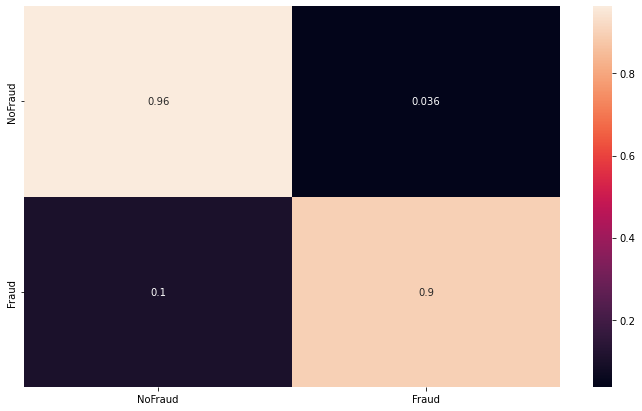

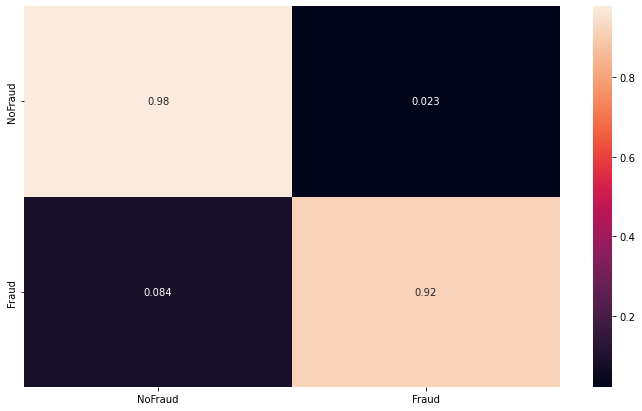

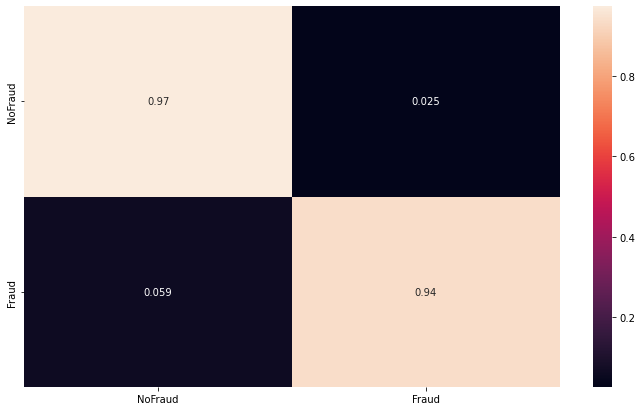

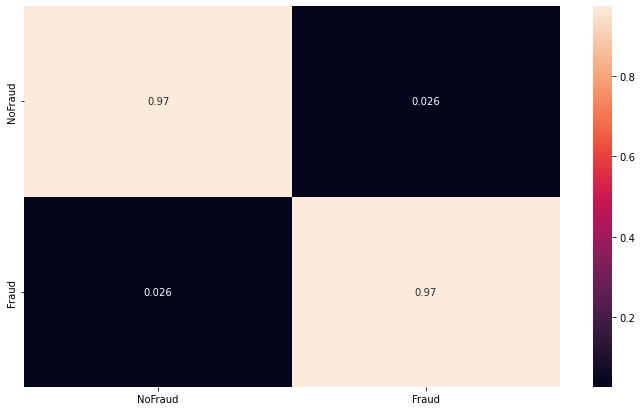

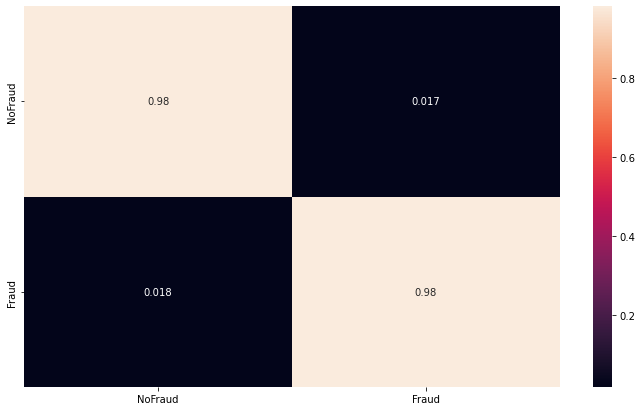

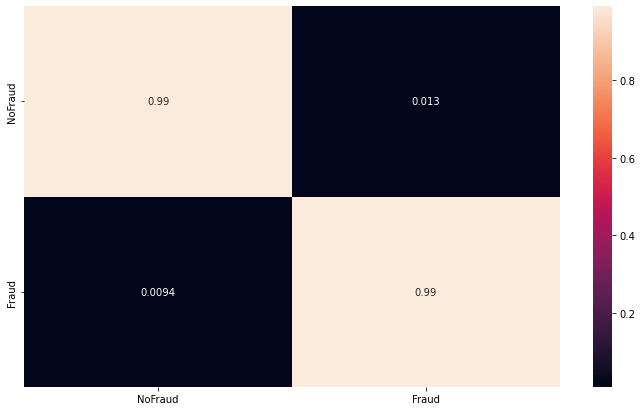

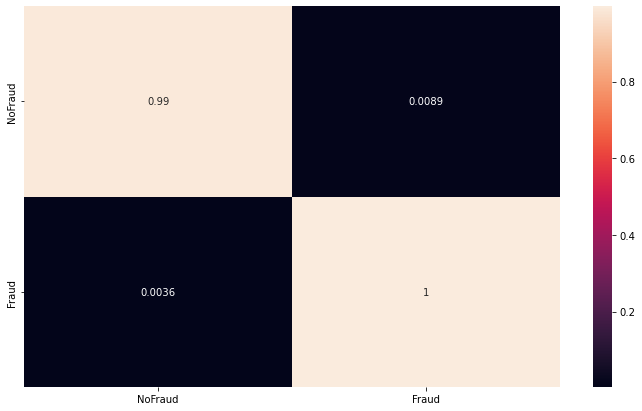

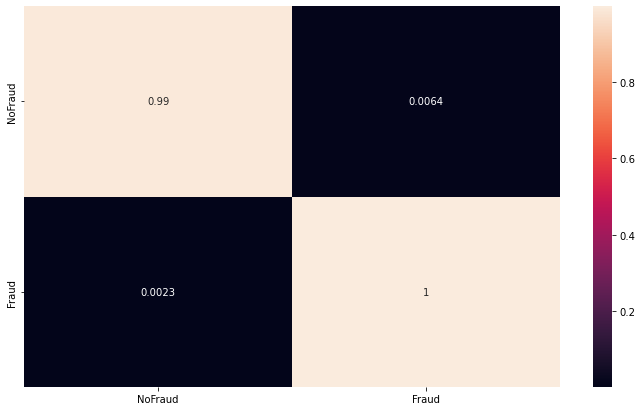

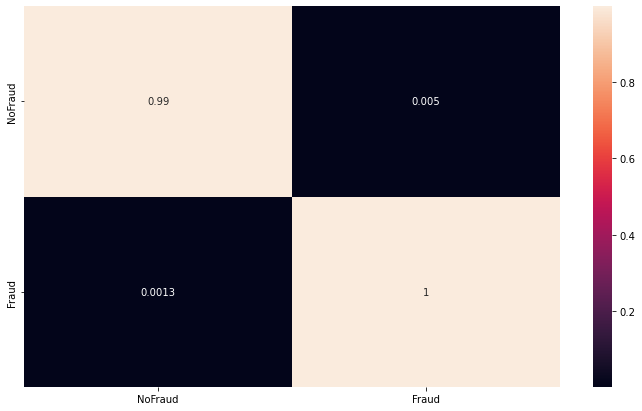

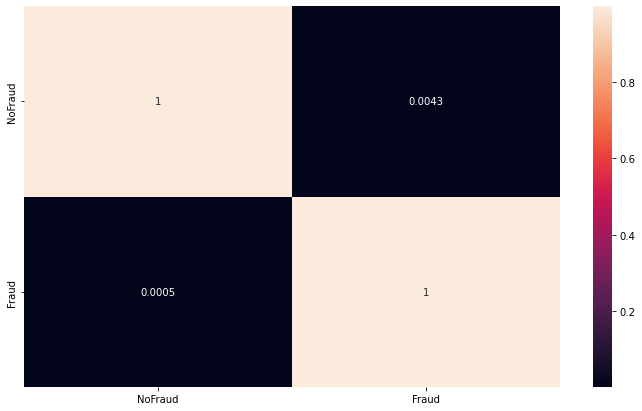

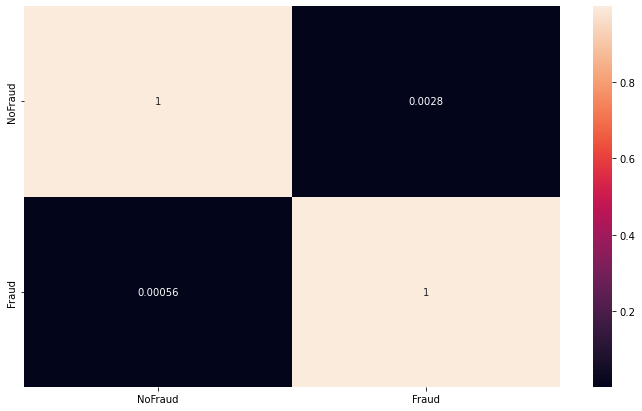

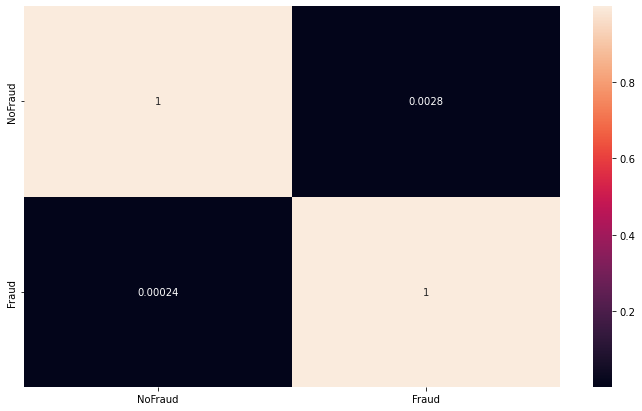

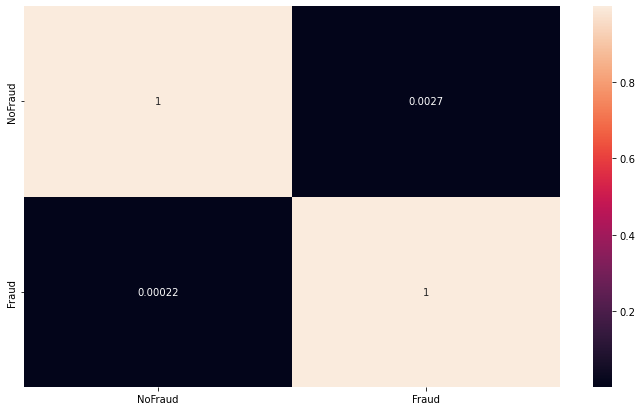

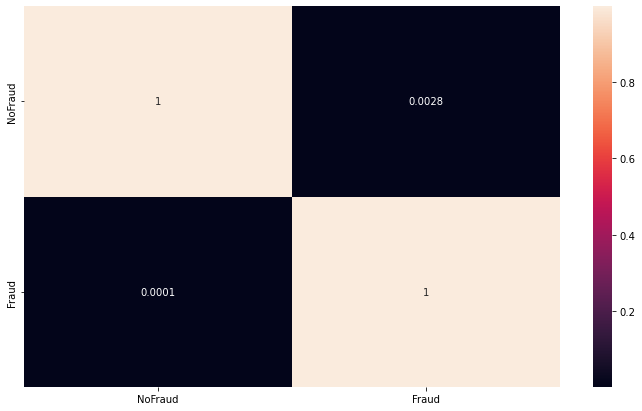

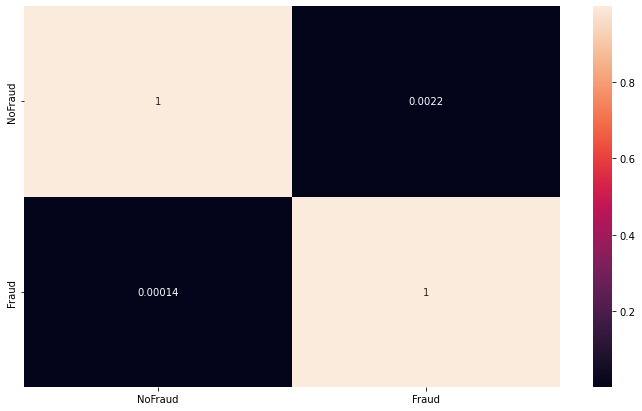

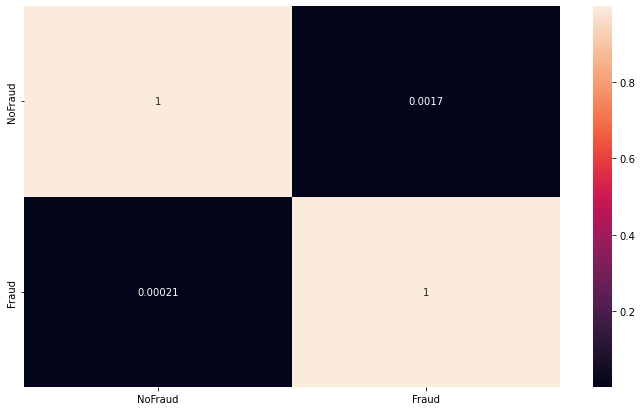

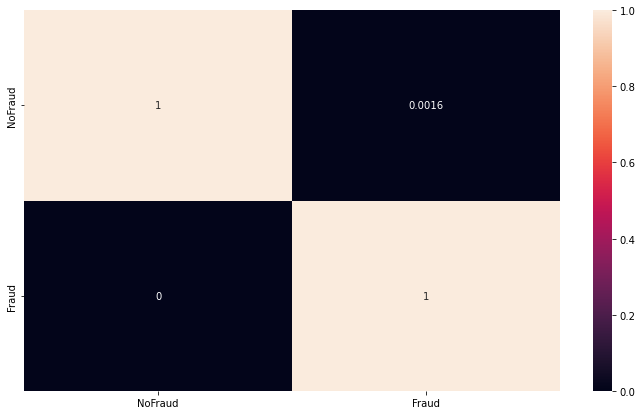

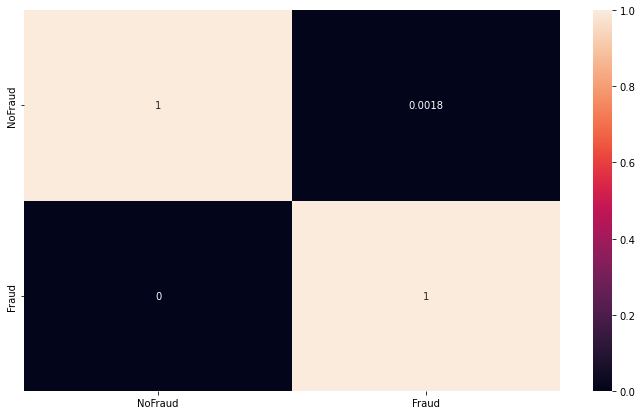

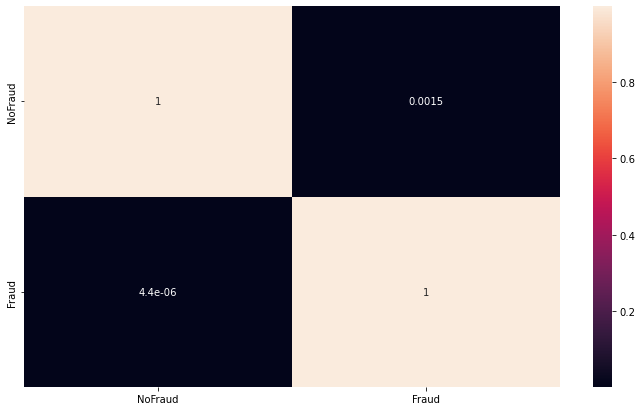

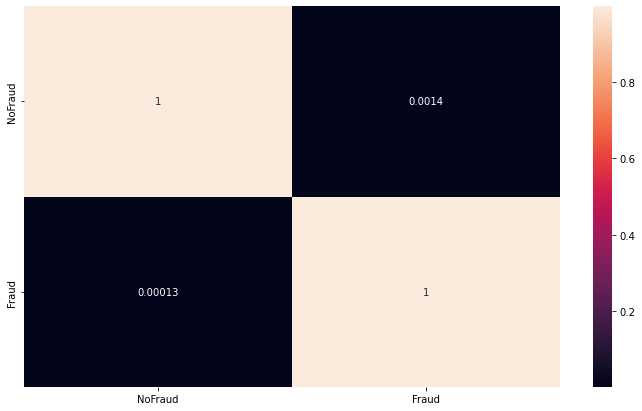

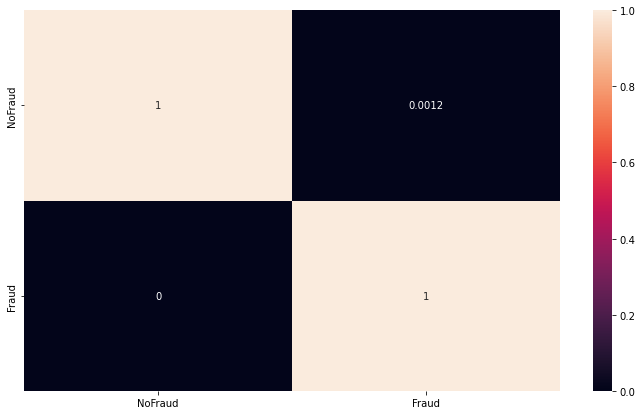

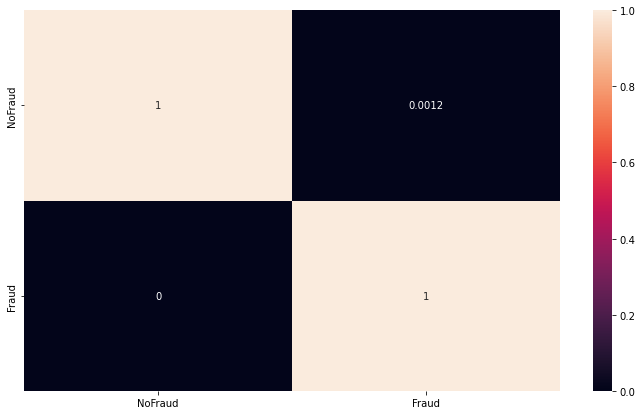

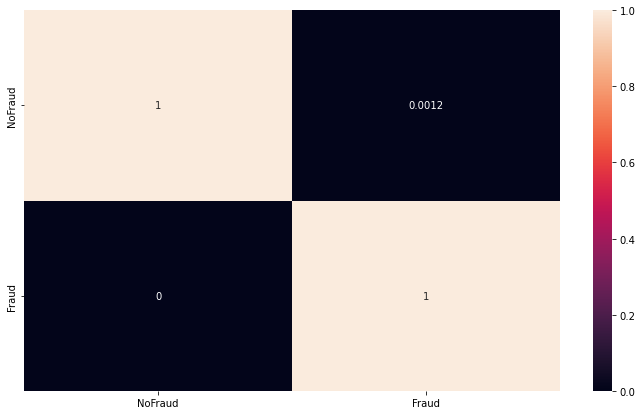

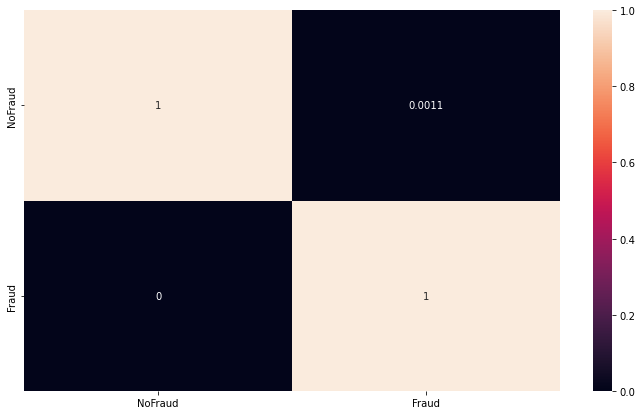

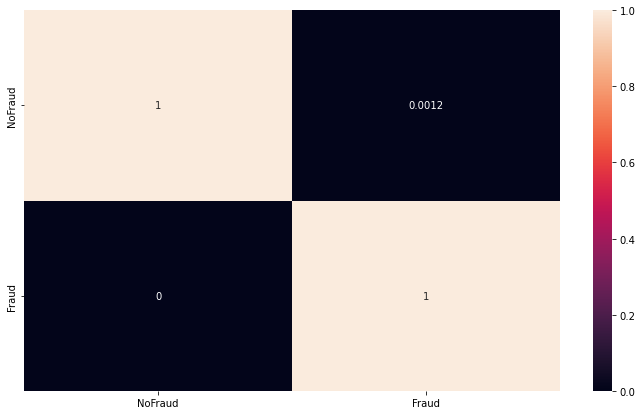

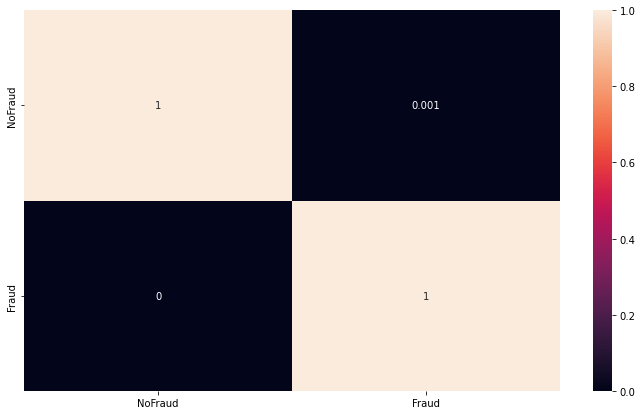

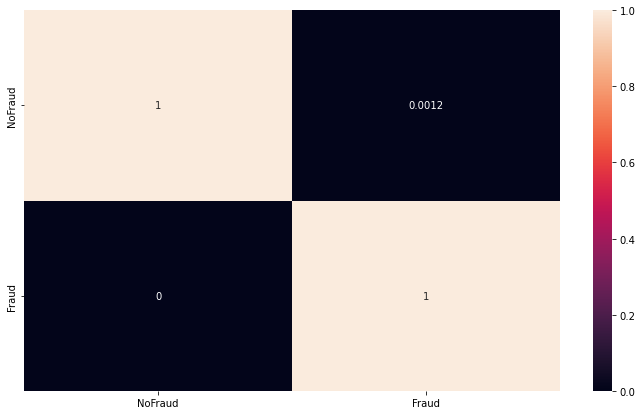

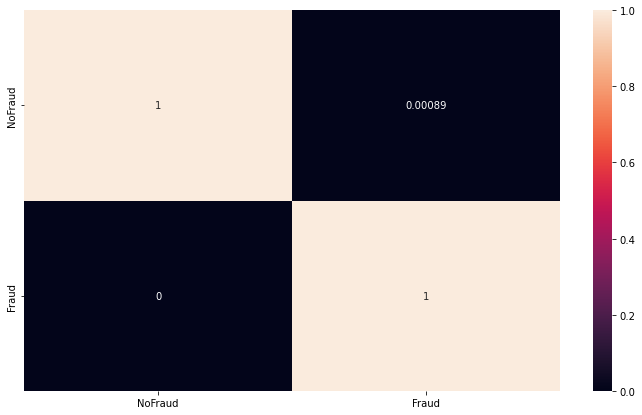

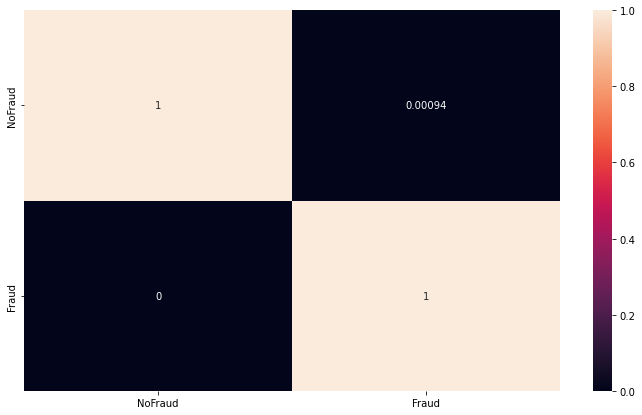

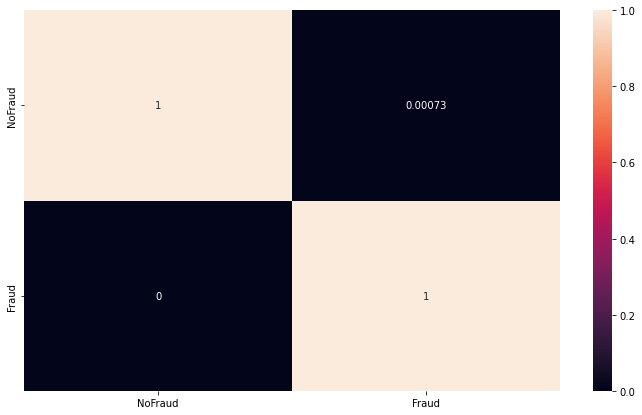

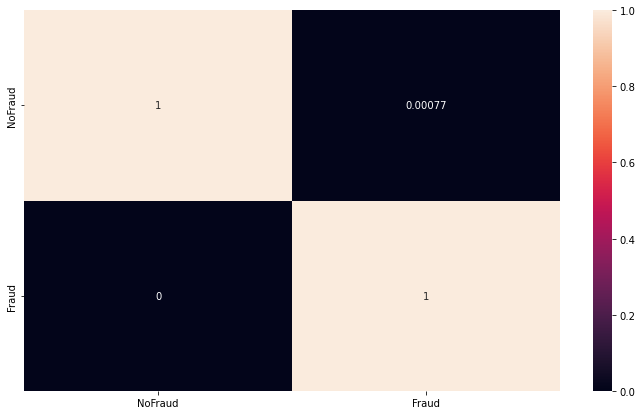

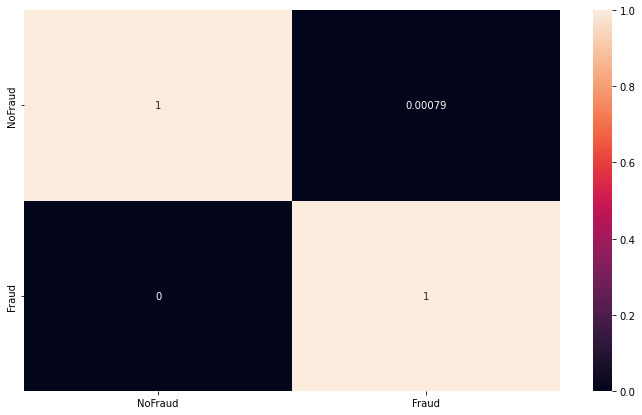

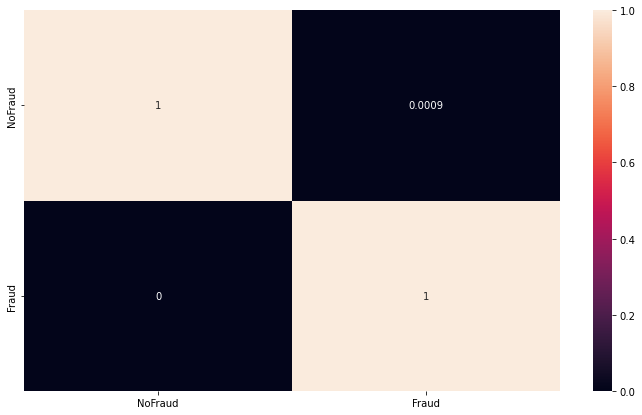

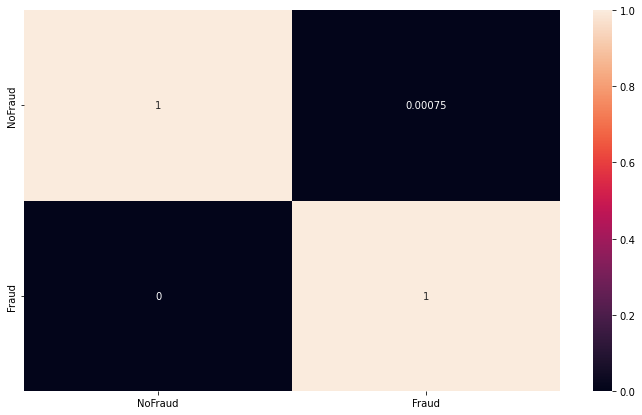

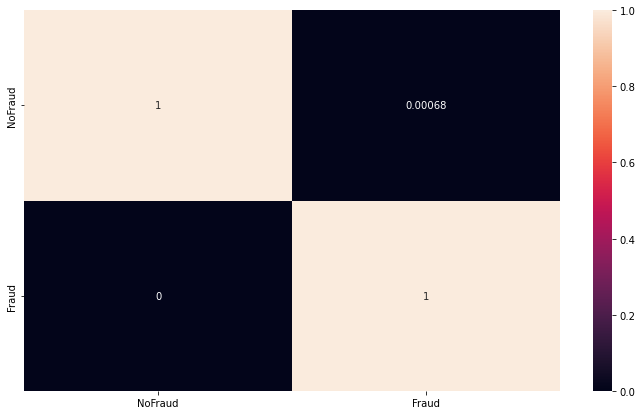

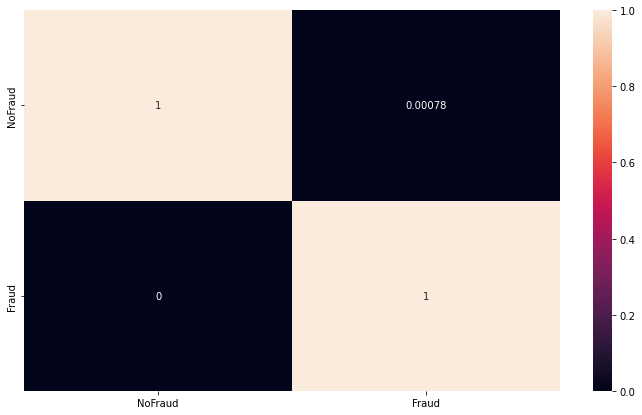

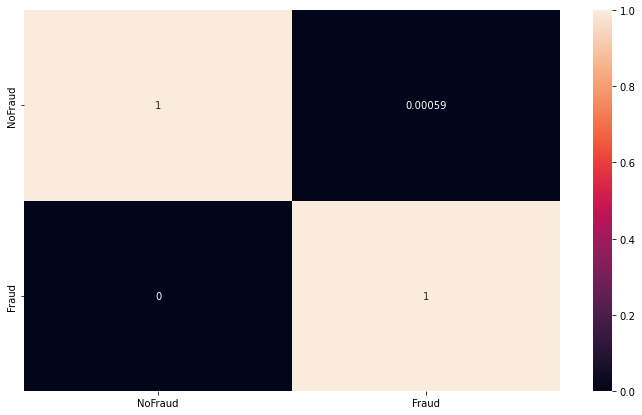

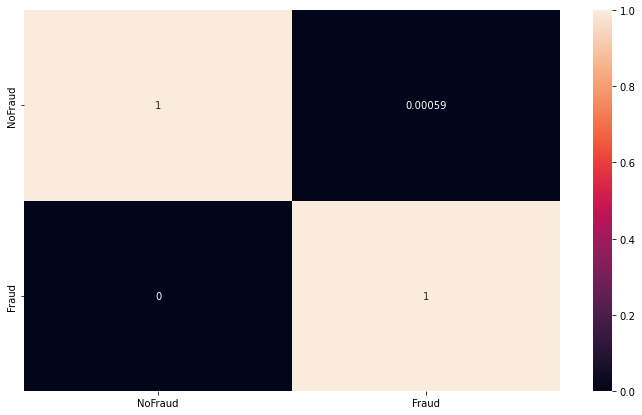

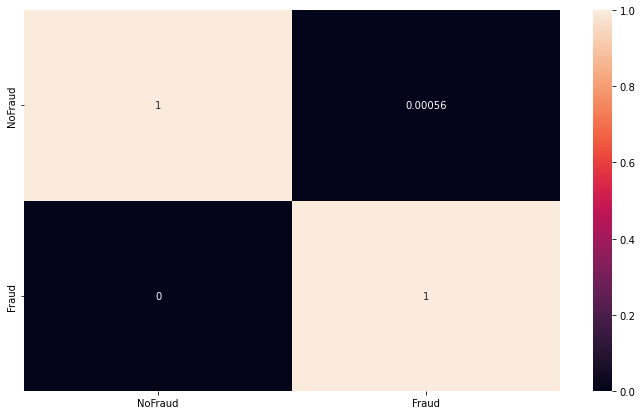

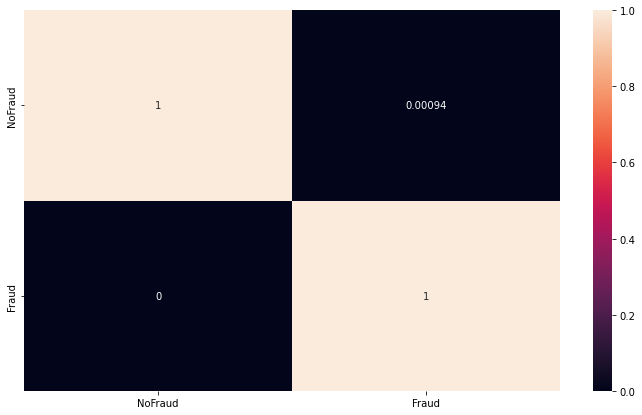

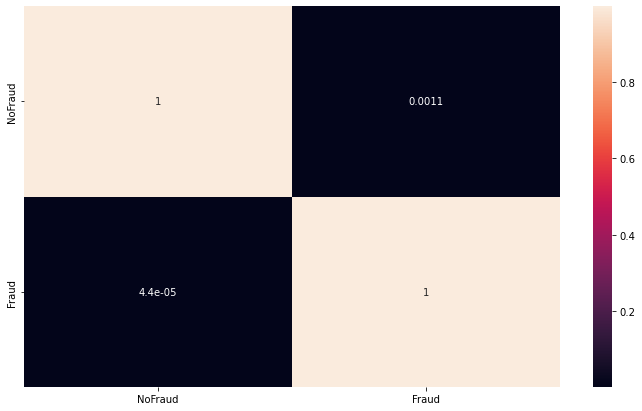

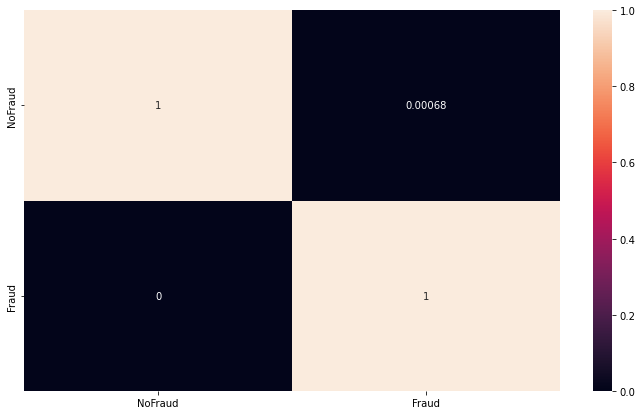

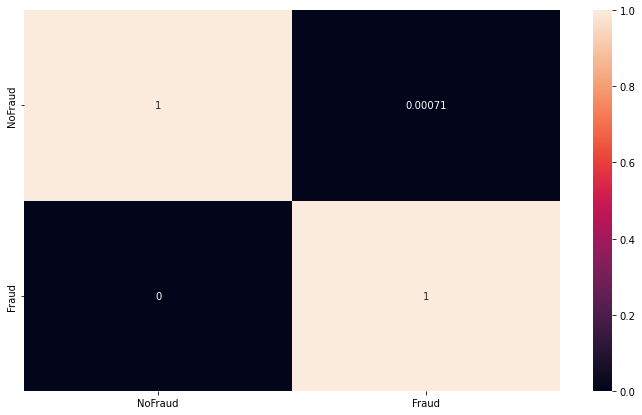

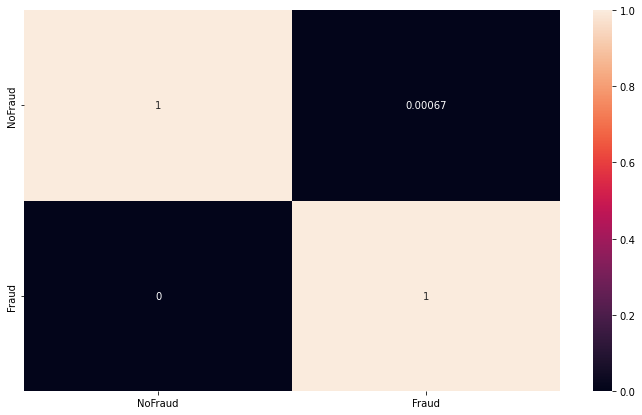

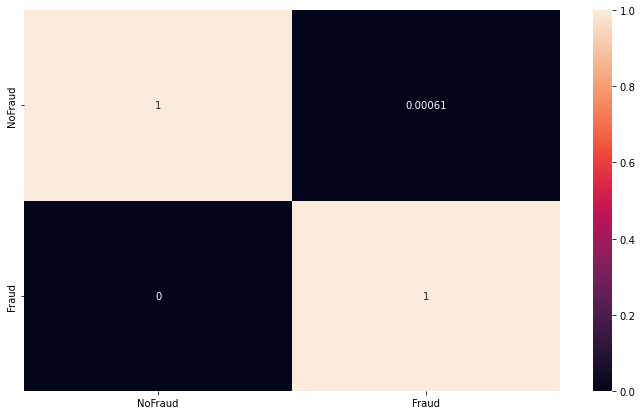

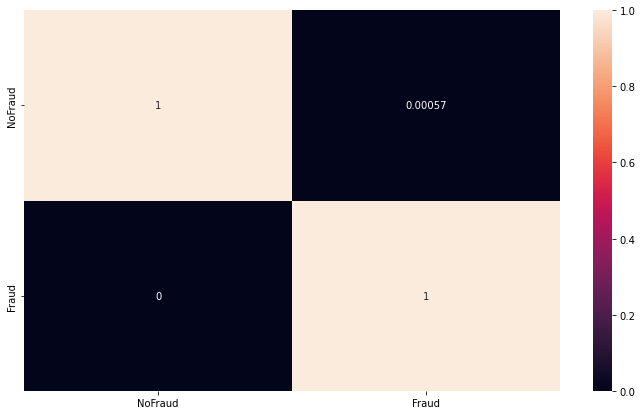

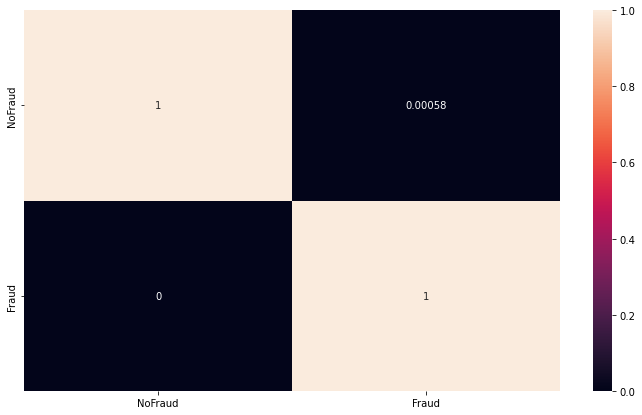

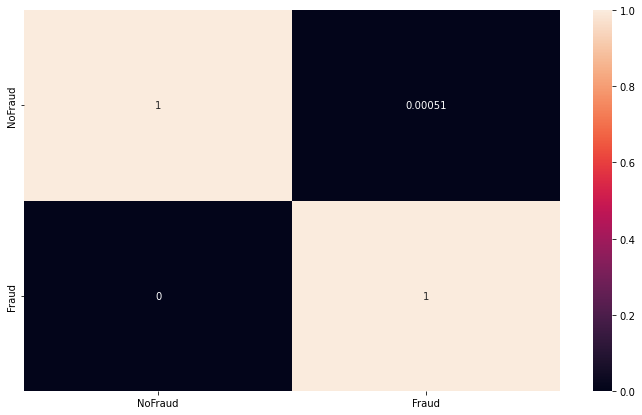

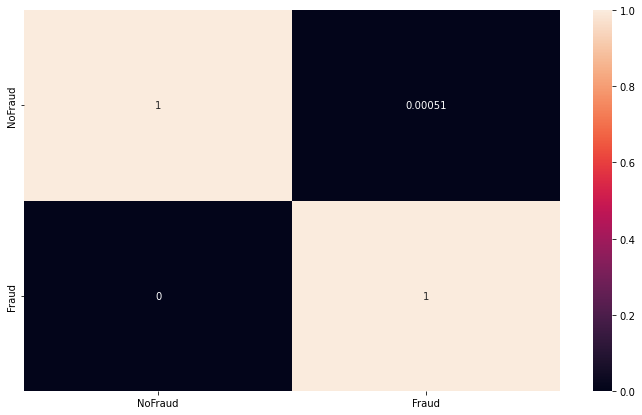

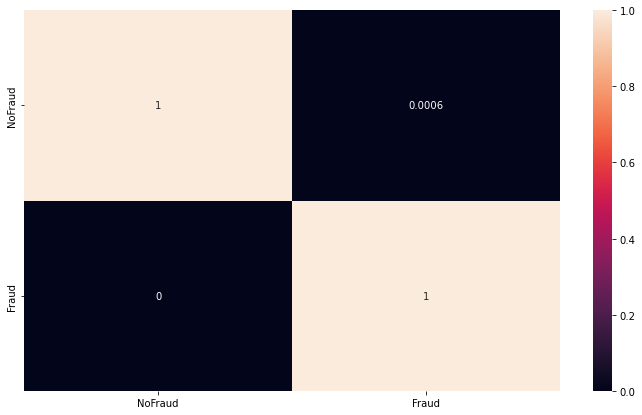

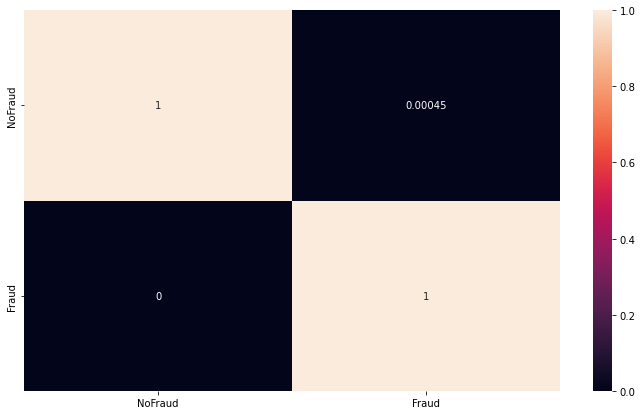

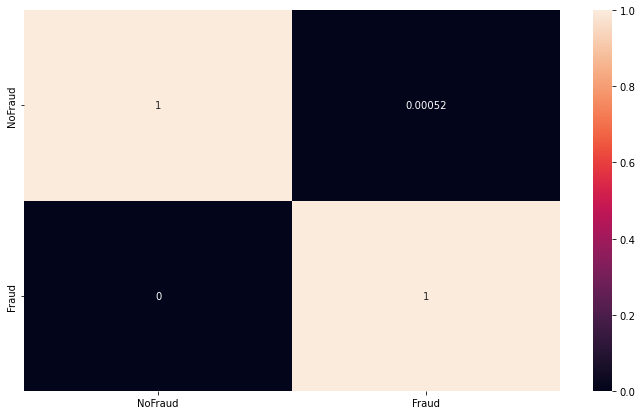

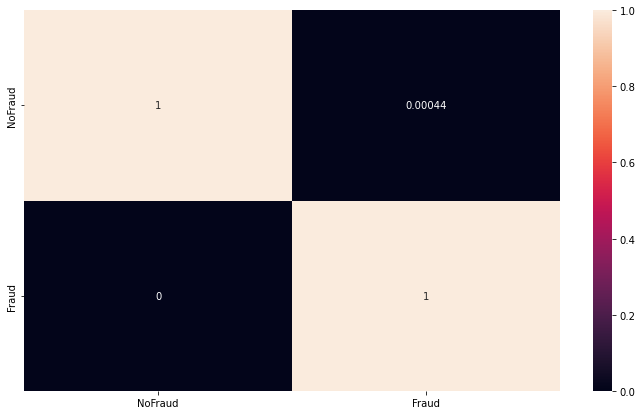

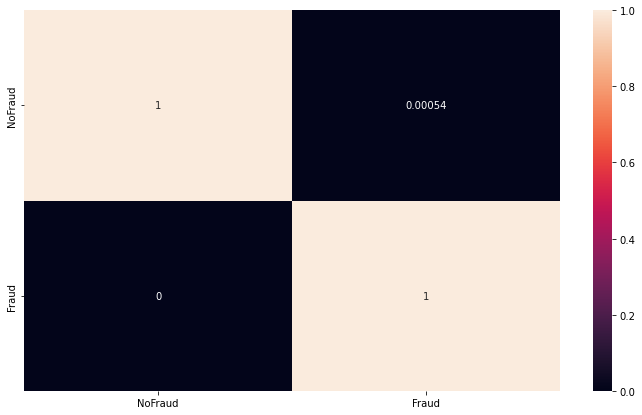

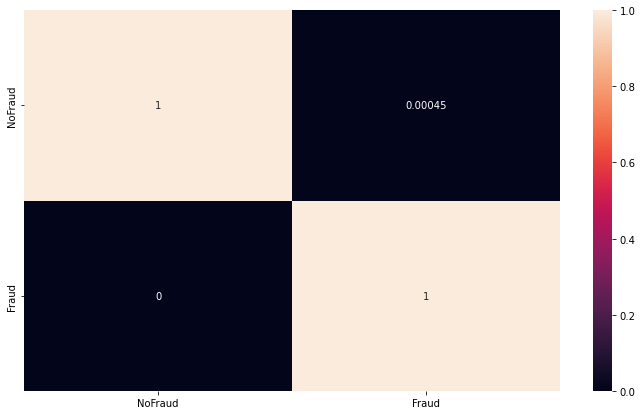

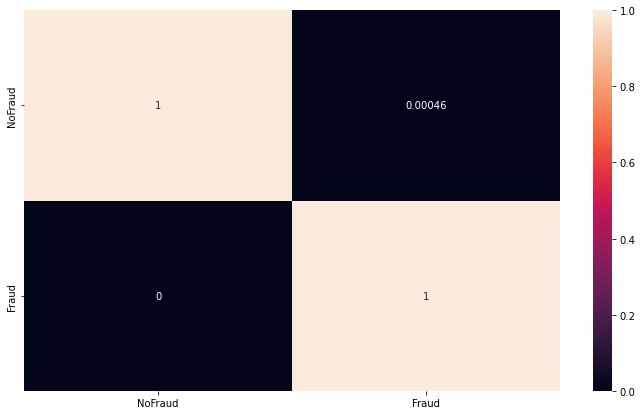

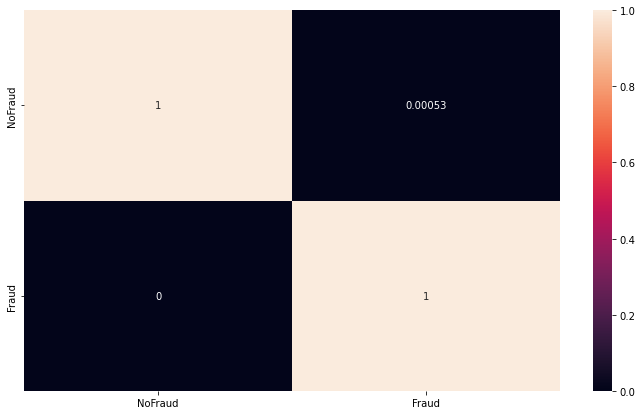

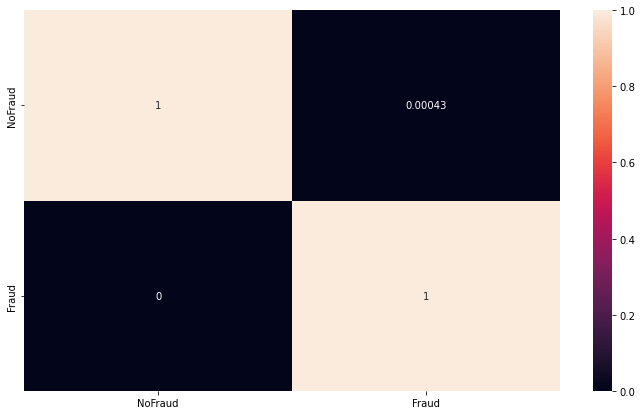

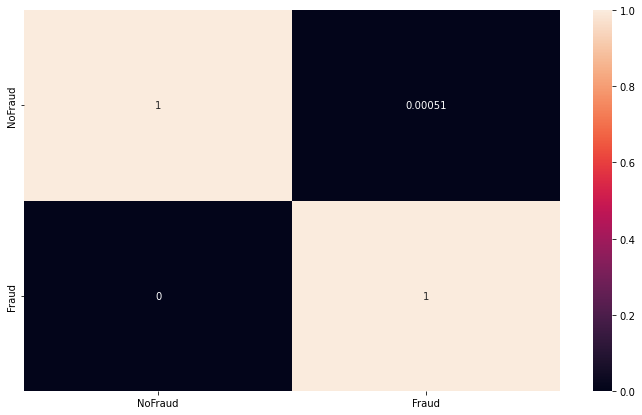

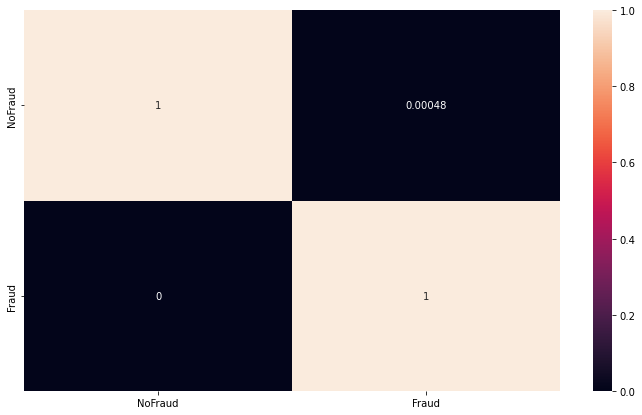

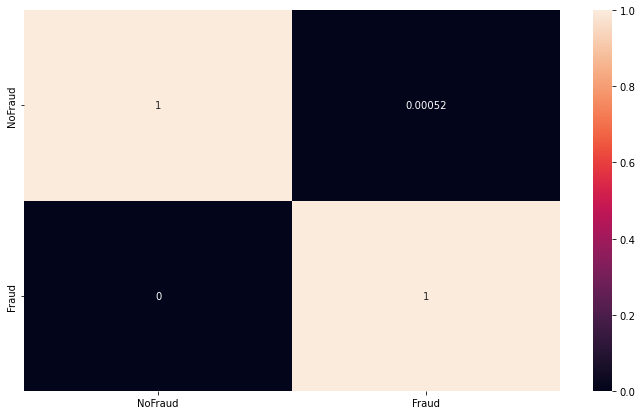

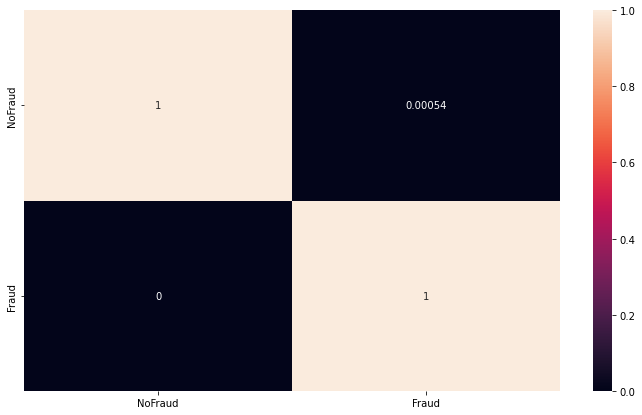

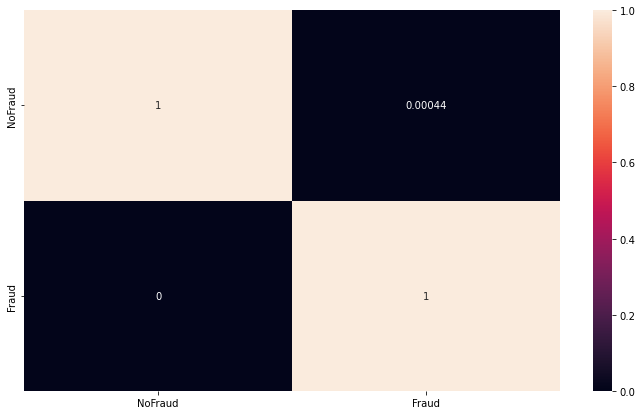

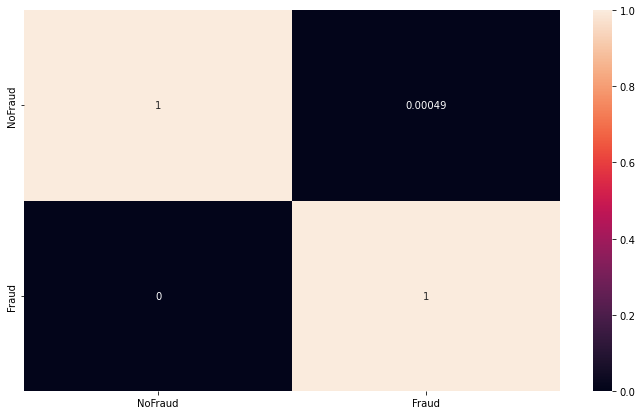

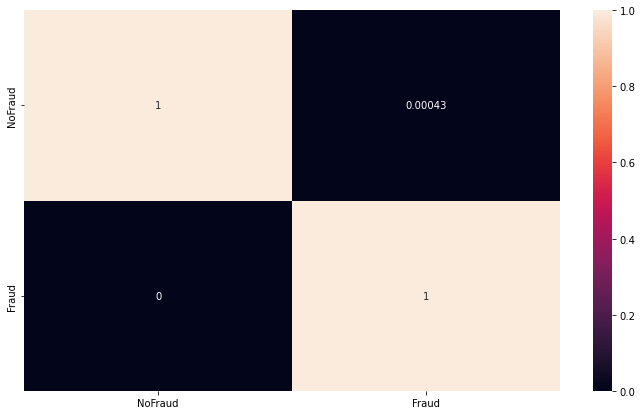

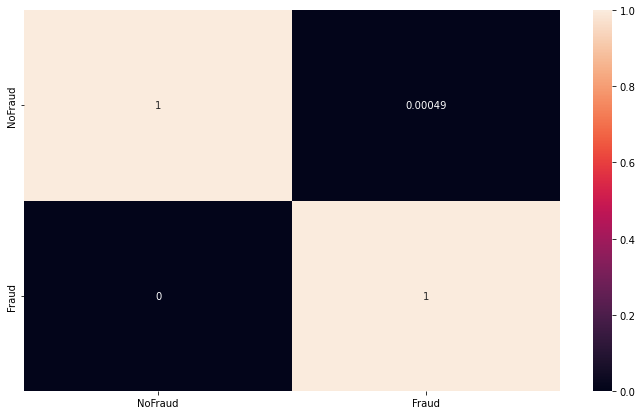

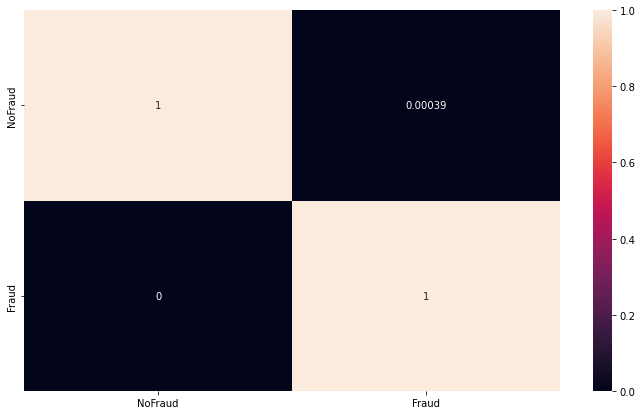

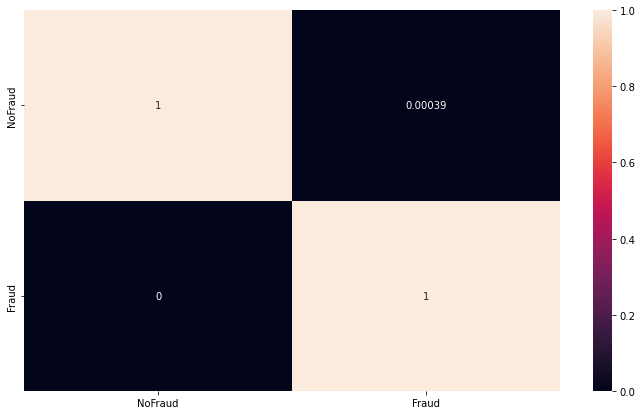

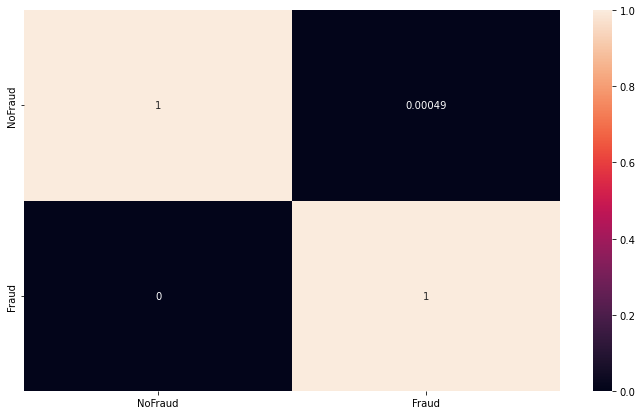

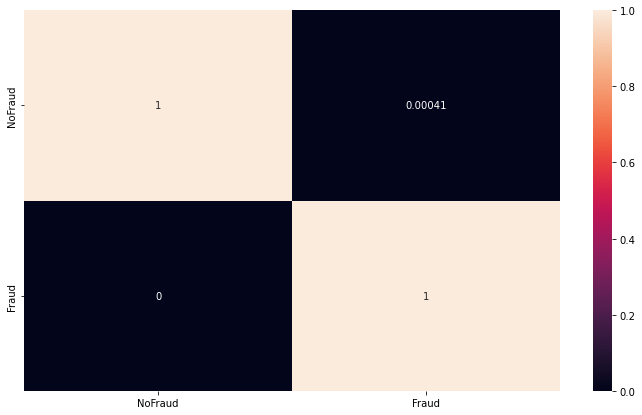

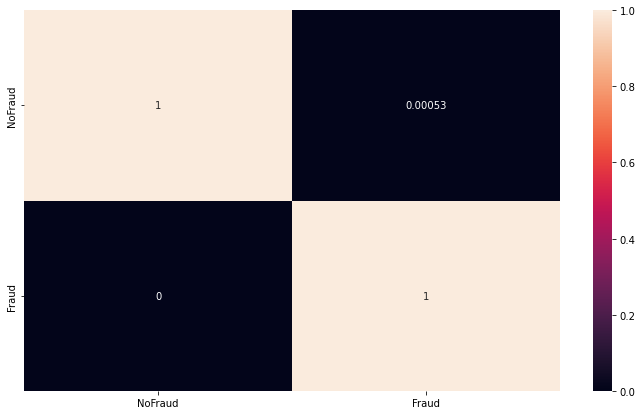

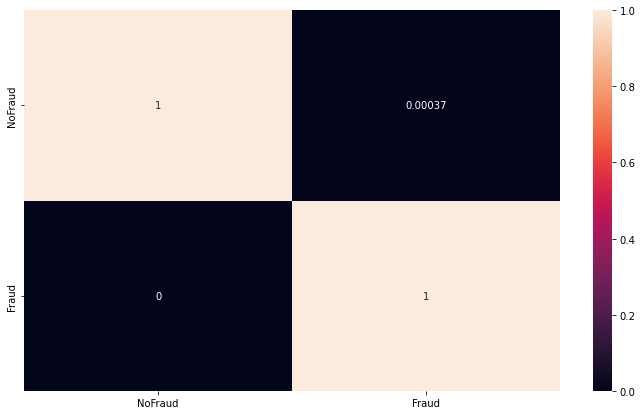

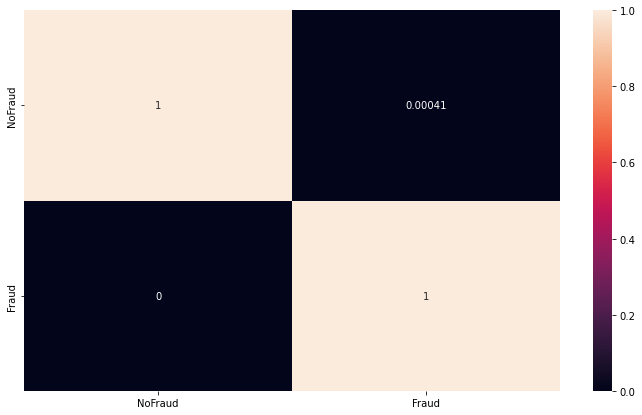

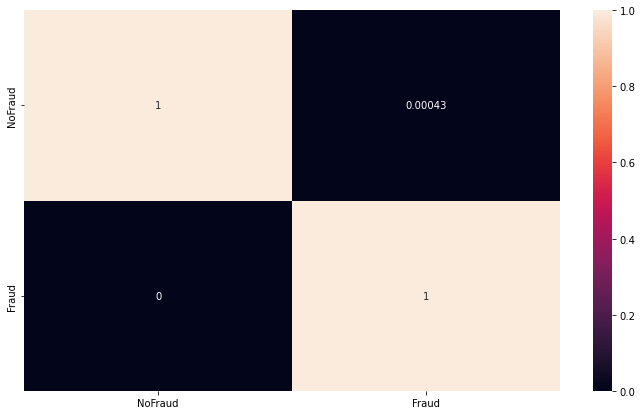

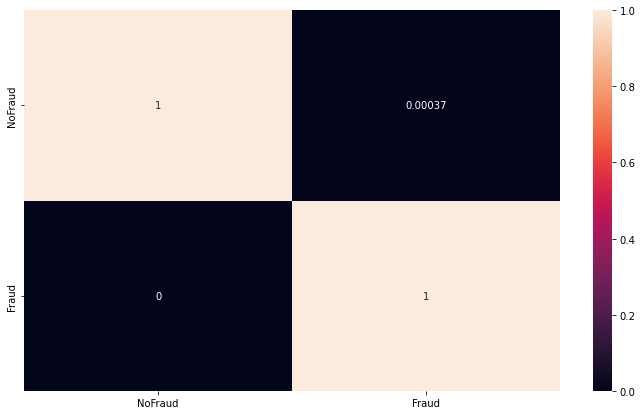

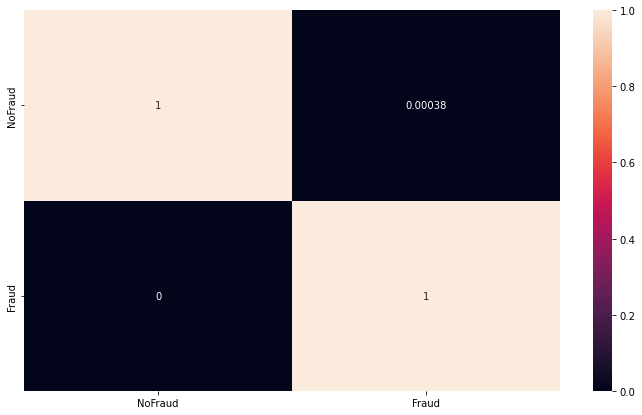

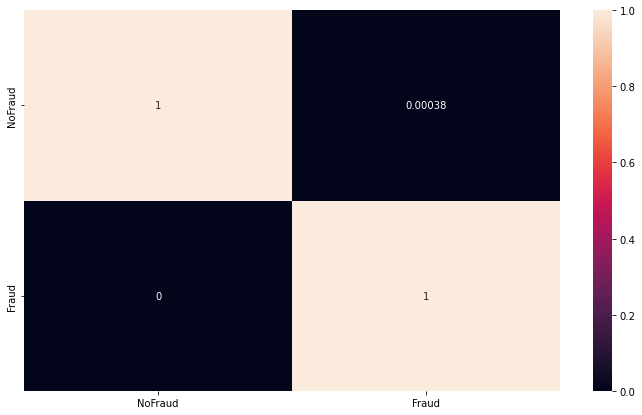

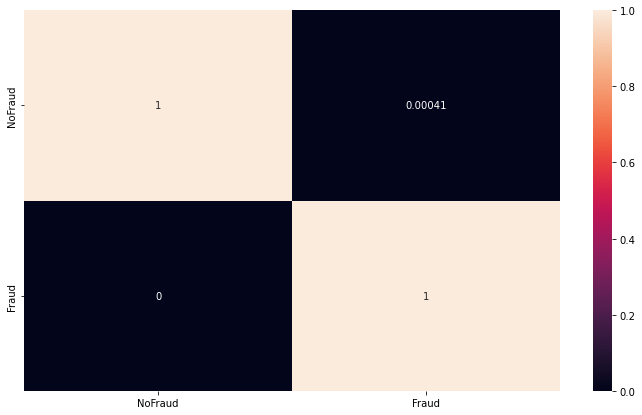

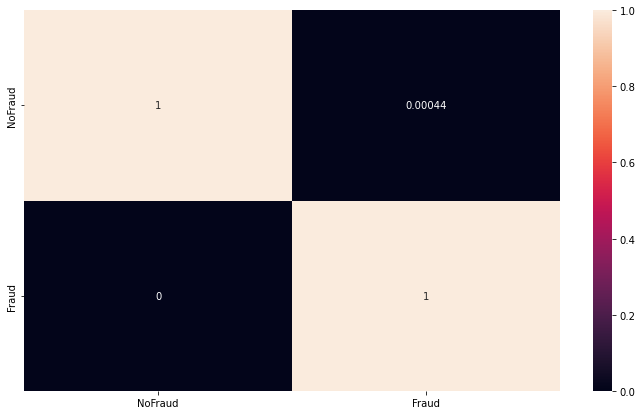

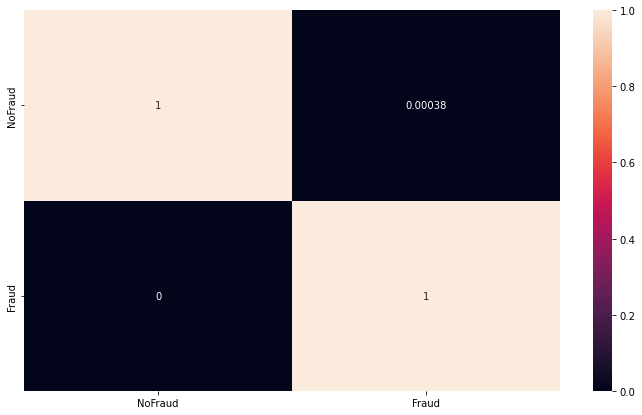

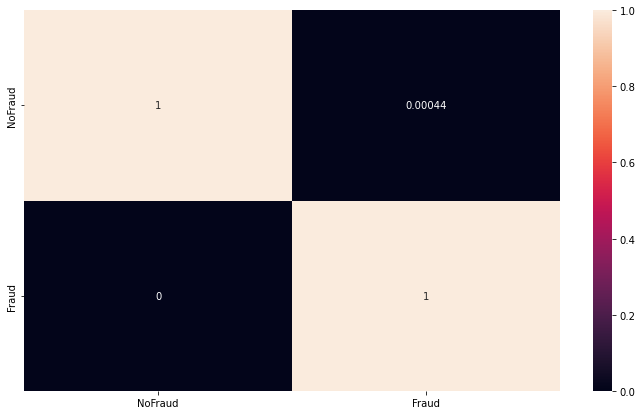

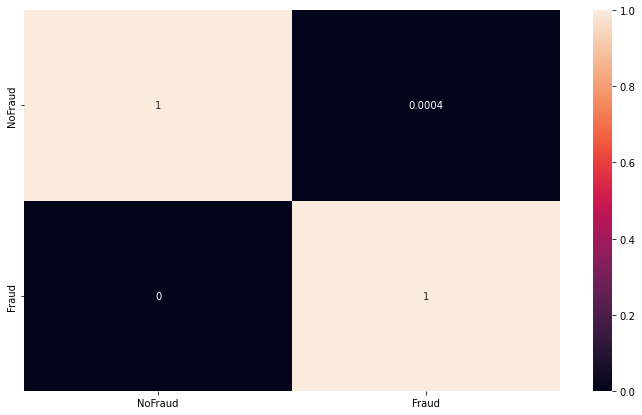

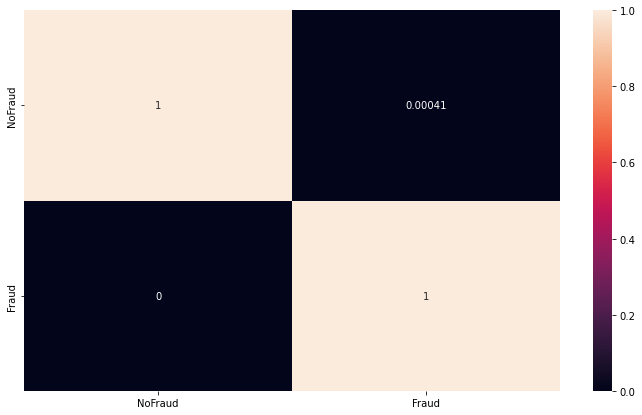

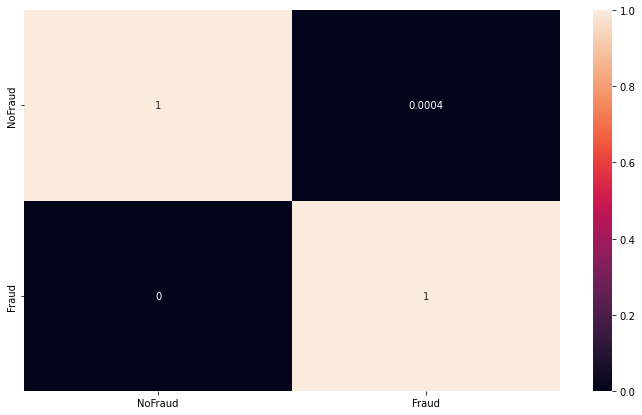

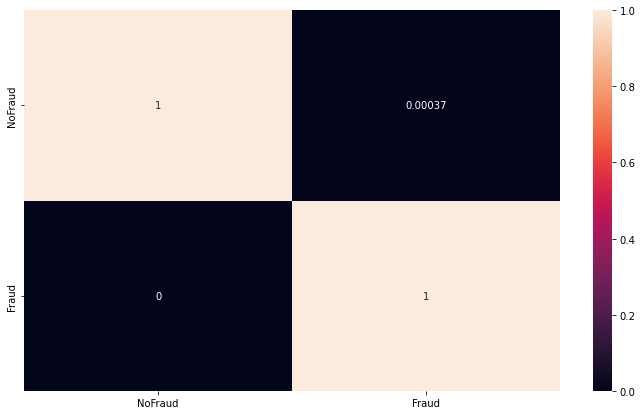

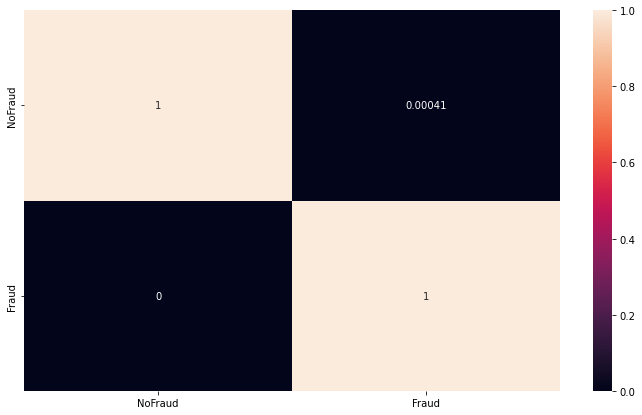

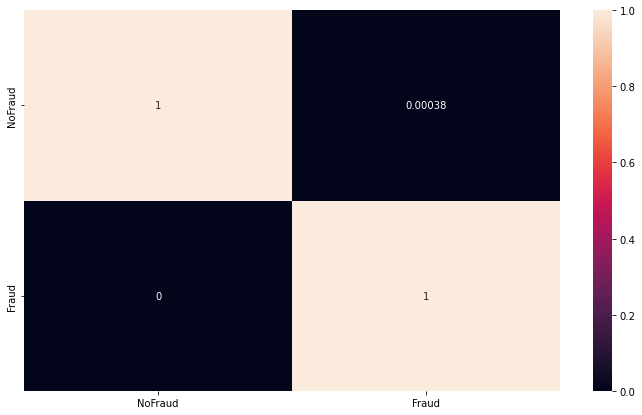

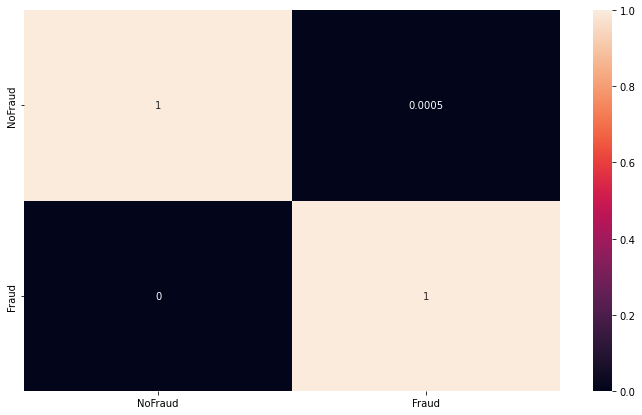

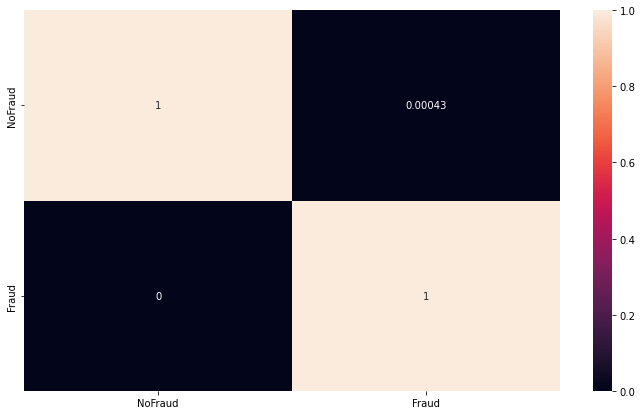

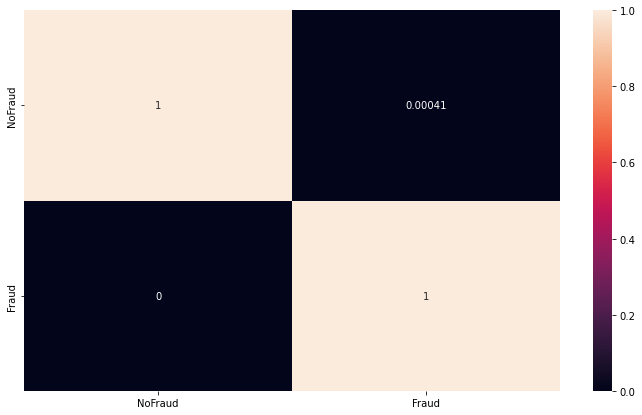

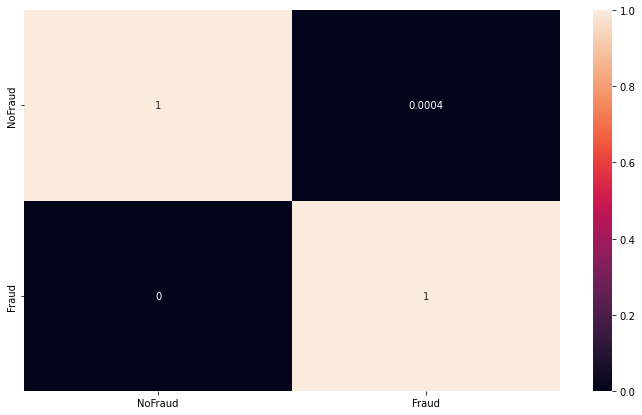

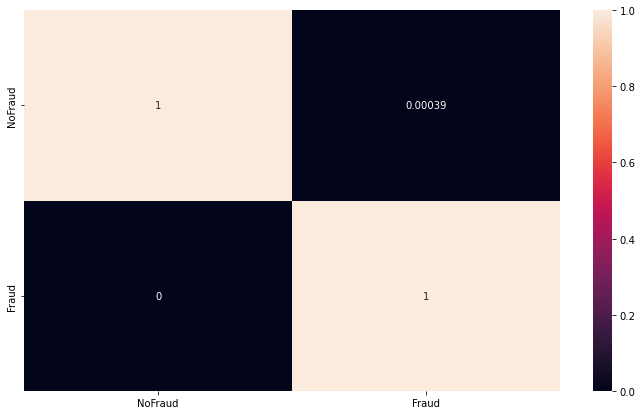

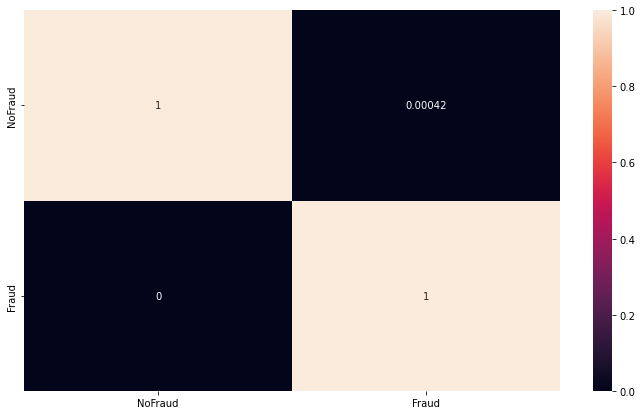

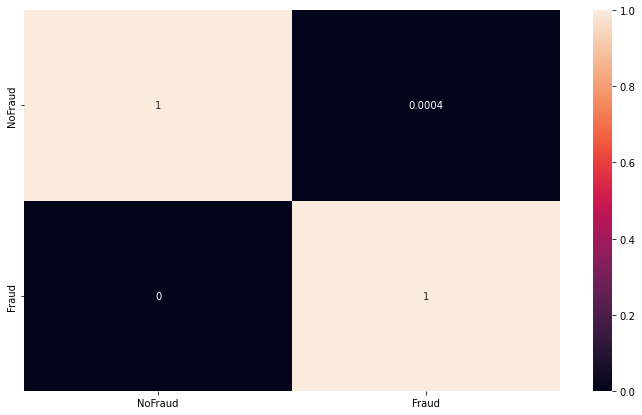

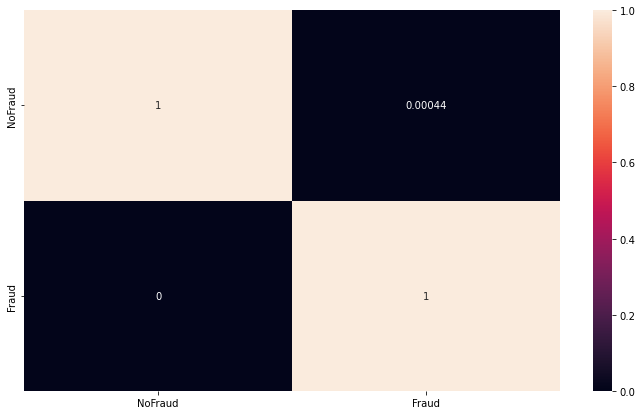

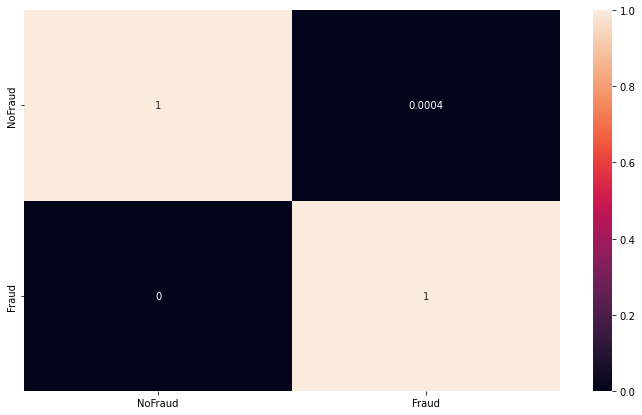

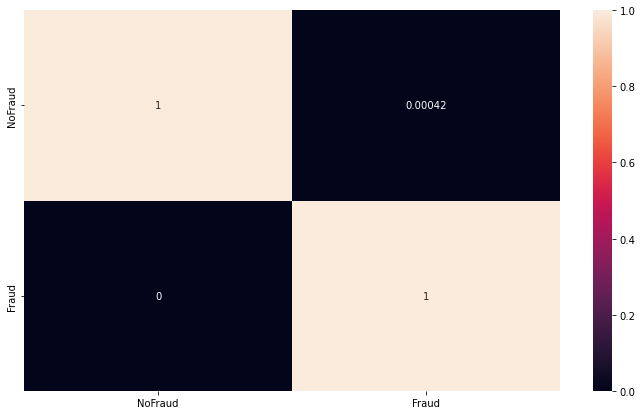

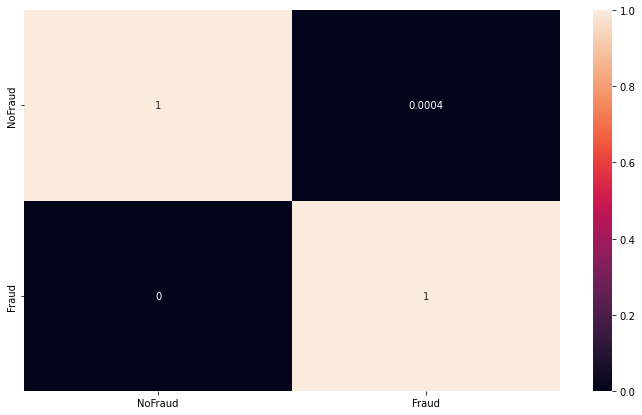

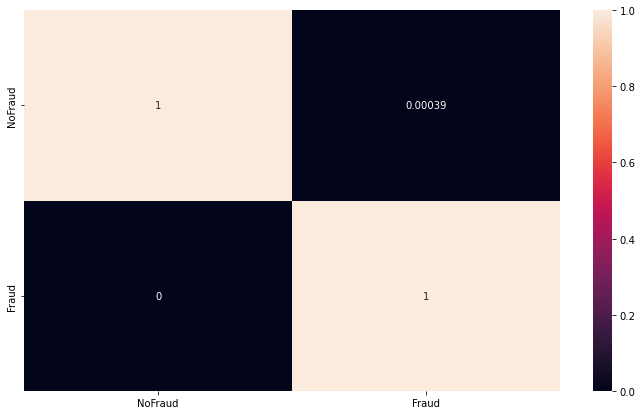

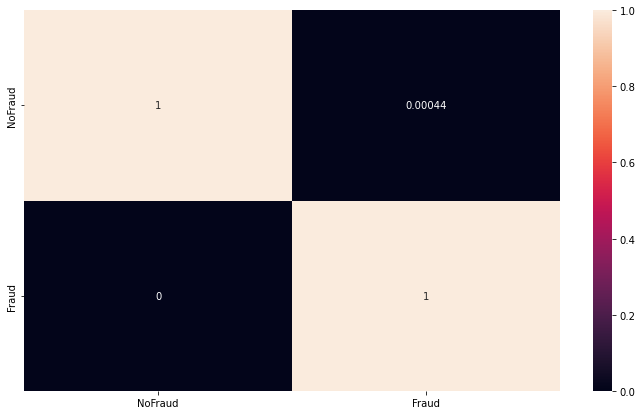

In [15]:
def compute_accuracy(model,features,targets):#, data_loader, device):
    correct_pred, num_examples = 0, 0
    features = features
    targets = targets
    logits, probas = model(features)
    _, predicted_labels = torch.max(probas, 1)
    num_examples += targets.size(0)
    correct_pred += (predicted_labels == targets).sum()

    print(classification_report(targets,predicted_labels))
    #Building Confusion matrix - https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

    # constant for classes
    classes = ('NoFraud','Fraud')

    # Build confusion matrix
    cf_matrix = confusion_matrix(targets, predicted_labels)
    #print(cf_matrix)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                         columns = [i for i in classes])
    #print(df_cm)
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')

    #calculate f1_score
    print("F1 Score: ",f1_score(targets, predicted_labels))

    return correct_pred.float()/num_examples * 100


start_time = time.time()
minibatch_cost = []



#Split X (features) and y (targets) for the dataset
#X=np.delete(train_dataset,-1,axis=1)
#y = np.delete(train_dataset,np.s_[0:28],axis=1).flatten()
features_full = torch.tensor(X, dtype=torch.float).to(DEVICE)
targets_full = torch.tensor(y, dtype=torch.long).to(DEVICE)
# create DataLoader, then take one batch

#Data loader for text data in Pytorch - https://machinelearningmastery.com/training-a-pytorch-model-with-dataloader-and-dataset/
#loader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=16)
#for X_batch, y_batch in loader:
#    print(X_batch, y_batch)
#    break

for epoch in range(NUM_EPOCHS):

    loader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=40000)
    model1.train()
    for batch_idx, (X_batch, y_batch) in enumerate(loader):
        #print(epoch, len(X_batch), len(y_batch))
        ### FORWARD AND BACK PROP
        features = torch.tensor(X_batch, dtype=torch.float).to(DEVICE)
        targets = torch.tensor(y_batch, dtype=torch.long).to(DEVICE)
        logits, probas = model1(features)

        cost = F.cross_entropy(logits, targets)
        
        optimizer.zero_grad()

        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        #if not batch_idx % 50:
        print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
               %(epoch+1, NUM_EPOCHS, batch_idx, 
                 len(loader), cost))

    model1.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model1, features_full, targets_full)))#, train_loader, device=DEVICE)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

In [16]:
df_train.head()

,amount_scaled,time_scaled,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.221666,-0.377686,-2.884963,-1.589646,1.428892,-0.231664,0.703769,-1.135737,1.374058,-1.270979,...,-1.467870,-0.561406,1.176544,1.317806,0.552698,0.080118,1.087925,0.008199,-0.826939,0
1,-0.055764,-0.682481,1.346320,-0.487437,0.592587,-0.777410,-1.044706,-0.716309,-0.615366,-0.069492,...,0.117686,-0.034576,-0.262912,0.110504,0.311770,0.206979,-0.500379,0.006710,0.014698,0
2,-0.292032,-0.000781,-1.218391,-0.255592,2.260171,-2.202368,0.837064,0.202872,0.026945,0.005451,...,0.053011,-0.106944,0.299457,-0.607956,-0.825759,0.491154,-0.750612,-0.015709,-0.364491,0
3,0.917675,0.139183,1.857971,-0.028326,-1.670878,1.474285,0.567250,-0.580874,0.491246,-0.306005,...,-0.214325,-0.031796,0.130834,-0.103224,-0.469414,0.391725,-0.530875,-0.066009,-0.069885,0
4,-0.268530,-0.081481,-0.656697,1.012916,1.444790,0.157903,0.034674,-0.868656,0.610683,-0.007874,...,0.032794,-0.192946,-0.458896,0.210743,0.554074,-0.281893,0.060908,0.145721,0.083991,0


<br>
<br>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.64      0.86      0.74        95

    accuracy                           1.00     56746
   macro avg       0.82      0.93      0.87     56746
weighted avg       1.00      1.00      1.00     56746

F1 Score:  0.7354260089686099
Test accuracy: 99.90%


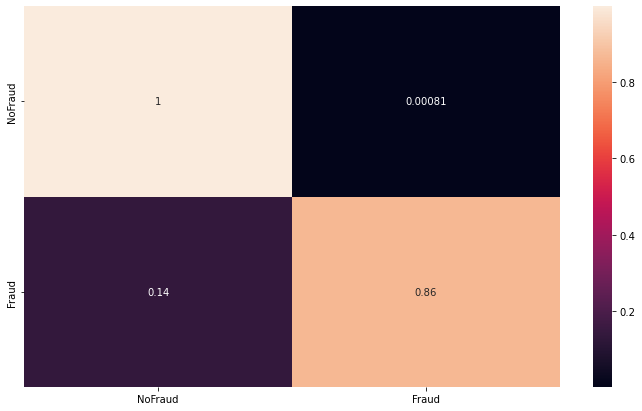

In [17]:
##########################
### Evaluation and Acccuracy Confusion Matrix
##########################

#Split X (features) and y (targets) for the test dataset
X=np.delete(test_dataset,-1,axis=1)
y = np.delete(test_dataset,np.s_[0:30],axis=1).flatten()
features = torch.tensor(X, dtype=torch.float).to(DEVICE)
targets = torch.tensor(y, dtype=torch.long).to(DEVICE)


with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model1, features, targets)))

In [18]:
df_test

,amount_scaled,time_scaled,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.585315,0.496708,1.795396,-0.679893,-2.017149,0.373530,0.156962,-0.647662,0.356176,-0.085573,...,-0.129223,0.098182,-0.004840,-0.002430,0.698182,0.061198,0.552722,-0.150157,-0.065977,0
1,0.139063,0.490527,1.951712,-0.228398,-1.287975,0.358102,-0.167054,-0.662379,-0.309588,-0.004453,...,-0.150099,-0.049865,-0.101636,0.149538,-0.424921,-0.314548,0.539700,-0.055480,-0.039511,0
2,-0.236546,-0.500621,-0.670156,0.138234,1.594335,-2.603667,-0.067365,0.033324,-0.133867,0.049504,...,-0.071288,0.513661,1.336197,-0.304077,-0.718541,-0.185255,-0.385508,-0.120496,0.150383,0
3,-0.295230,-0.081140,-5.794754,4.645318,-2.586418,-1.739302,-2.313447,-1.294582,-1.705959,2.205806,...,0.071667,0.188248,-0.390025,0.412940,-0.123767,0.237768,0.636582,-2.028767,-0.181068,0
4,-0.295369,-0.336119,-0.363330,1.312914,0.916321,0.087972,0.698580,-1.027009,1.209270,-0.413487,...,0.110402,-0.014168,0.100200,-0.281481,0.469766,0.039546,0.252019,-0.280492,-0.151930,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56741,-0.292032,0.035332,-1.408237,1.127313,-1.258562,-3.705687,2.810907,2.938534,0.480564,1.061995,...,0.175023,-0.333284,-0.912678,-0.046377,0.696372,0.027212,0.361984,0.026929,-0.004269,0
56742,0.534279,0.389520,-0.895772,0.528892,-0.821451,-1.126928,2.305078,4.107840,-0.030652,1.516626,...,0.116105,-0.247463,-0.608114,0.044880,0.693311,0.107718,-0.396525,0.279153,0.129212,0
56743,2.510082,0.088908,1.884212,-0.892753,-2.254782,-0.003984,0.166636,-0.940280,0.467723,-0.726433,...,-0.213482,0.093018,0.920985,-0.503289,-0.597942,0.803337,0.310793,-0.079019,-0.051566,0
56744,0.432624,0.359188,-0.247652,0.315038,1.392573,-1.108713,-0.154744,-0.076194,-0.088506,-0.716030,...,-0.199791,0.557210,-1.065112,-0.368474,0.668873,1.493208,-0.697437,0.079177,0.160387,0
